# CS5131 Project
### Predicting the Myers-Briggs Personality Type of a person via input text
James Sng, Tan Pin Che

# Introduction

The Myers-Briggs Type Indicator is a commonly used framework that attempts to classify the personality of individuals by assigning them four binary categories, namely introversion/extroversion, intuition/sensory, thinking/feeling, and perceiving/judging. These four categories are then combined to give a four-letter code, such as INTP or ESFJ, giving sixteen possible types overall.

Existing methods of determining a person's MBTI type involve the taking of a questionaire, where the responses are then used to determine the type of a person. These tests can be time-consuming. Additionally, questions in such questionaires tend to be repetitive and thus, people's familiarity with the questions and what they attempt to predict could create bias when their responses are entered. Thus, by predicting based off free-form text, we attempt to eliminate this bias while attempting an alternate method of prediction. 

## Objective

In this project, we attempt to develop a Machine Learning algorithm that can predict the MBTI type of a person based on text they enter into the program. Due to our training data, which is sourced from social media sites, the program is intended to be used with conversational text, such as that from one's messages or emails. By attempting different models, vectorization methods, and methods of prediction, we attempt to obtain the highest possible accuracy. Additionally, by contrasting the different results given by different methods of prediction, we may also gain insight into the machinations of the framework.

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CS5131_Project/MBTI_500.csv')
data

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ
...,...,...
106062,stay frustrate world life want take long nap w...,INFP
106063,fizzle around time mention sure mistake thing ...,INFP
106064,schedule modify hey w intp strong wing underst...,INFP
106065,enfj since january busy schedule able spend li...,INFP


This dataset consists of preprocessed posts of different people on social media sites such as Reddit. In particular, every entry has been processed to contain exactly 500 words.

 As some preliminary data analysis, we first check the distribution of the different types:

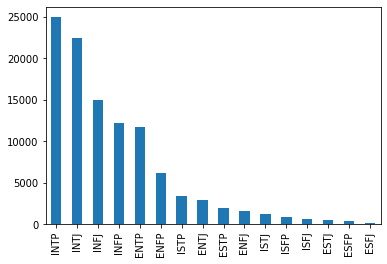

In [ ]:
data['type'].value_counts().plot(kind='bar')

We note that there are much more records of introverted types than extroverted in general (as expected of internet users). In particular, types like ESFJ and ESFP have so few records that the model will be very unlikely to predict them. Thus, resampling may be necessary when applying the Machine Learning models later.

In [ ]:
types = data['type'].unique()
types

array(['INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
       'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ', 'INFP'],
      dtype=object)

We do see that we have all sixteen types represented to some degree, however.

Now, for further analysis later, we split each type into its four functions. For context, the MBTI is characterised by eight different functions, with each type being characterised by four of the eight functions. 

In [ ]:
def toFunction(data):
  data['I/E'] = data['type'].str[0]
  data.loc[((data['I/E'] == 'I') & (data['type'].str[3] == 'J')) | ((data['I/E'] == 'E') & (data['type'].str[3] == 'P')), 'dominant_auxiliary'] = data.loc[((data['I/E'] == 'I') & (data['type'].str[3] == 'J')) | ((data['I/E'] == 'E') & (data['type'].str[3] == 'P')), "type"].str[1:3]
  data.loc[data['dominant_auxiliary'].isnull(), 'dominant_auxiliary'] = data.loc[data['dominant_auxiliary'].isnull(), "type"].str[-2:-4:-1]
  return data

In [ ]:
data = toFunction(data)
data

,posts,type,I/E,dominant_auxiliary
0,know intj tool use interaction people excuse a...,INTJ,I,NT
1,rap music ehh opp yeah know valid well know fa...,INTJ,I,NT
2,preferably p hd low except wew lad video p min...,INTJ,I,NT
3,drink like wish could drink red wine give head...,INTJ,I,NT
4,space program ah bad deal meing freelance max ...,INTJ,I,NT
...,...,...,...,...
106062,stay frustrate world life want take long nap w...,INFP,I,FN
106063,fizzle around time mention sure mistake thing ...,INFP,I,FN
106064,schedule modify hey w intp strong wing underst...,INFP,I,FN
106065,enfj since january busy schedule able spend li...,INFP,I,FN


Now checking the distribution of the functions:

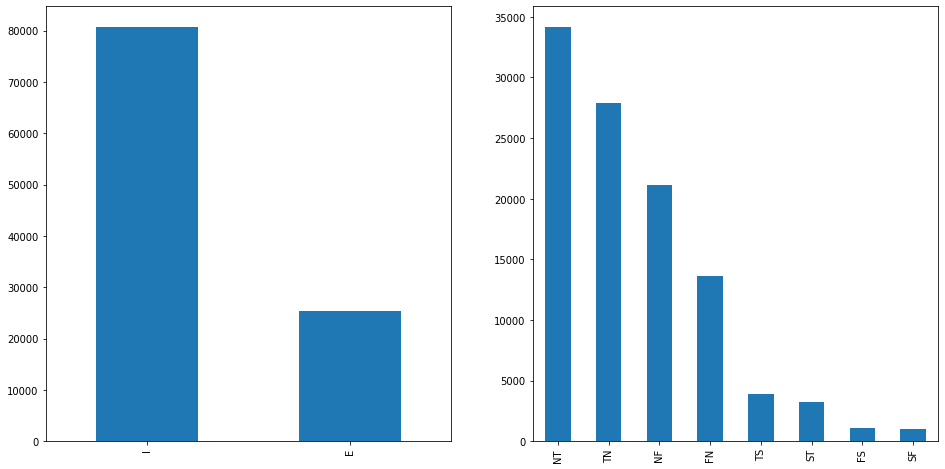

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
data['I/E'].value_counts().plot(kind='bar',ax=ax[0])
data['dominant_auxiliary'].value_counts().plot(kind='bar',ax=ax[1])

There is a clear disparity in the functions that we have, resulting from the disparity that came from the types. To avoid error due to this, we attempt to do resampling later.

To vectorize each entry, we try both the Bag of Words and TF-IDF representations, and test them against each other later.

In [ ]:
vectorizer = CountVectorizer()
x_bag = vectorizer.fit_transform(data['posts'])

In [ ]:
vectorizer = TfidfVectorizer()
x_tfidf = vectorizer.fit_transform(data['posts'])

# Direct Prediction


In this section, we attempt many different models to attempt to predict the whole type of a person at once. The models we have attempted include:

- Naive-Bayes
- Support Vector Machines
- K-Nearest Neighbours
- Random Forests
- Logistic Regression
- Neural Network

We also attempt to use both the Bag of Words and TF-IDF vectorizations to find the better accuracy. Additionally, resampling and dimensionality reduction using a Truncated SVD are applied when necessary to reduce computation load. We also attempt to tune relevant hyperparameters for models where doing so is relevant, which will be elaborated more on in the sections for the specific models.

We first make a list that will store all the data we obtain for our results.

In [ ]:
results = np.zeros(shape=(9, 2)).tolist()
results

[[0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0]]

The following section displays in turn the results for the different models we have tested. For tuning of specific hyperparameters, details regarding the optimal value of the parameter will be described in the corresponding section. General analysis of the best model choice will be performed at the end.

## Multinomial Naive Bayes with Bag of Words (Baseline Model)


In [ ]:
x = x_bag
y = data['type']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
nb = MultinomialNB(alpha = 1)
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
results[0][0] = nb.score(x_test, y_test)
nb.score(x_test, y_test)

0.677807108513246

In [ ]:
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        ENFJ       0.14      0.01      0.02       322
        ENFP       0.86      0.14      0.23      1228
        ENTJ       0.97      0.19      0.32       623
        ENTP       0.76      0.63      0.69      2361
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        83
        ESTJ       1.00      0.37      0.54        98
        ESTP       0.97      0.66      0.79       397
        INFJ       0.57      0.81      0.67      2972
        INFP       0.63      0.67      0.65      2401
        INTJ       0.70      0.85      0.77      4514
        INTP       0.70      0.88      0.78      4964
        ISFJ       0.00      0.00      0.00       135
        ISFP       0.00      0.00      0.00       177
        ISTJ       0.00      0.00      0.00       243
        ISTP       0.86      0.16      0.27       663

    accuracy                           0.68     21214
   macro avg       0.51   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Multinomial Naive Bayes with TF-IDF + Resampling

In [ ]:
x = x_tfidf
y = data['type']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
over = SMOTE(sampling_strategy = dict(np.maximum(y_train.value_counts(), 2000)))
r_x_train, r_y_train = over.fit_resample(x_train, y_train)
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(r_y_train.value_counts(), 2000)))
r_x_train, r_y_train = under.fit_resample(r_x_train, r_y_train)

In [ ]:
over = SMOTE(sampling_strategy = dict(np.maximum(y_test.value_counts(), 100)))
r_x_test, r_y_test = over.fit_resample(x_test, y_test)
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(r_y_test.value_counts(), 100)))
r_x_test, r_y_test = under.fit_resample(r_x_test, r_y_test)

In [ ]:
nb = MultinomialNB(alpha = 1)
nb.fit(r_x_train, r_y_train)
y_pred = nb.predict(r_x_test)
results[0][1] = nb.score(r_x_test, r_y_test)
nb.score(r_x_test, r_y_test)

0.703125

In [ ]:
print(classification_report(r_y_test, y_pred))

              precision    recall  f1-score   support

        ENFJ       0.71      0.74      0.73       100
        ENFP       0.47      0.72      0.57       100
        ENTJ       0.96      0.76      0.85       100
        ENTP       0.81      0.50      0.62       100
        ESFJ       0.94      0.80      0.86       100
        ESFP       0.78      0.91      0.84       100
        ESTJ       0.99      0.72      0.83       100
        ESTP       1.00      0.84      0.91       100
        INFJ       0.37      0.87      0.51       100
        INFP       0.59      0.36      0.45       100
        INTJ       0.62      0.61      0.61       100
        INTP       0.73      0.61      0.66       100
        ISFJ       0.76      0.74      0.75       100
        ISFP       0.74      0.67      0.70       100
        ISTJ       0.81      0.81      0.81       100
        ISTP       0.81      0.59      0.68       100

    accuracy                           0.70      1600
   macro avg       0.75   

## Complement Naive Bayes with Bag of Words


In [ ]:
x = x_bag
y = data['type']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
nb = ComplementNB(alpha = 1)
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
results[1][0] = nb.score(x_test, y_test)
nb.score(x_test, y_test)

0.7615725464316018

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        ENFJ       0.86      0.10      0.18       322
        ENFP       0.86      0.46      0.60      1228
        ENTJ       0.91      0.67      0.77       623
        ENTP       0.84      0.74      0.79      2361
        ESFJ       0.00      0.00      0.00        33
        ESFP       1.00      0.04      0.07        83
        ESTJ       0.69      0.85      0.76        98
        ESTP       0.67      0.92      0.78       397
        INFJ       0.64      0.87      0.74      2972
        INFP       0.66      0.78      0.72      2401
        INTJ       0.84      0.80      0.82      4514
        INTP       0.78      0.88      0.82      4964
        ISFJ       0.67      0.01      0.03       135
        ISFP       0.72      0.10      0.18       177
        ISTJ       0.95      0.16      0.28       243
        ISTP       0.88      0.67      0.76       663

    accuracy                           0.76     21214
   macro avg       0.75   

## Complement Naive Bayes with TF-IDF

In [ ]:
x = x_tfidf
y = data['type']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
nb = ComplementNB(alpha = 1)
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
results[1][1] = nb.score(x_test, y_test)
nb.score(x_test, y_test)

0.5418591496181767

In [ ]:
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        ENFJ       0.67      0.01      0.01       322
        ENFP       0.91      0.02      0.03      1228
        ENTJ       0.98      0.33      0.49       623
        ENTP       0.92      0.18      0.30      2361
        ESFJ       0.00      0.00      0.00        33
        ESFP       1.00      0.01      0.02        83
        ESTJ       0.78      0.83      0.80        98
        ESTP       0.93      0.85      0.89       397
        INFJ       0.63      0.57      0.60      2972
        INFP       0.68      0.32      0.43      2401
        INTJ       0.59      0.70      0.64      4514
        INTP       0.44      0.95      0.60      4964
        ISFJ       0.00      0.00      0.00       135
        ISFP       0.50      0.01      0.01       177
        ISTJ       0.00      0.00      0.00       243
        ISTP       0.92      0.13      0.23       663

    accuracy                           0.54     21214
   macro avg       0.62   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LinearSVC with Bag Of Words + Resampling



For LinearSVC, we attempt to optimize the value of C by varying it from 0.00001 to 100, varying by an order of magnitude each time. 

In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_bag, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []
times = []

for c in c_values:
  start_time = time.time()
  svc = LinearSVC(C=c, class_weight='balanced', dual=True)
  svc.fit(x_train, y_train)
  print(f'C: {c}')
  score = svc.score(x_test, y_test)
  scores.append(score)
  print(score)
  y_pred = svc.predict(x_test)
  print(classification_report(y_test, y_pred))
  times.append(time.time() - start_time)

C: 1e-05
0.752948745442848
              precision    recall  f1-score   support

        ENFJ       0.81      0.71      0.76       311
        ENFP       0.78      0.77      0.77       403
        ENTJ       0.85      0.80      0.82       395
        ENTP       0.84      0.65      0.74       430
        ESFJ       0.38      0.86      0.53        42
        ESFP       0.44      0.80      0.57        71
        ESTJ       0.84      0.89      0.86       106
        ESTP       0.77      0.92      0.84       396
        INFJ       0.74      0.69      0.71       411
        INFP       0.70      0.70      0.70       378
        INTJ       0.78      0.70      0.74       367
        INTP       0.74      0.73      0.74       407
        ISFJ       0.62      0.74      0.67       120
        ISFP       0.61      0.75      0.67       167
        ISTJ       0.73      0.82      0.77       247
        ISTP       0.87      0.75      0.80       412

    accuracy                           0.75      4663

In [ ]:
scores

[0.752948745442848,
 0.7984130388162127,
 0.8003431267424405,
 0.7686039030666952,
 0.7514475659446708,
 0.7467295732361141,
 0.7463006648080635,
 0.7463006648080635]

In [ ]:
times

[16.35182213783264,
 19.31225037574768,
 24.613531351089478,
 31.17603087425232,
 40.255926847457886,
 43.19340491294861,
 42.59734654426575,
 41.07853388786316]

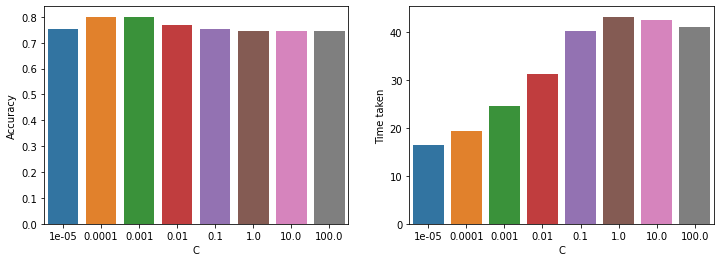

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=c_values, y=scores, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=c_values, y=times, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("Time taken")
plt.show()

We observe that the best values for the parameter C are 0.0001 and 0.001, having very similar scores that are slightly higher than ther rest. We choose to use C = 0.0001, since the difference in accuracy is marginal and doing so reduces the computation time.

In [ ]:
results[2][0] = scores[1]

## LinearSVC with TF-IDF + Resampling



We now attempt to perform the same analysis when using TF-IDF instead.

In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []
times = []

for c in c_values:
  start_time = time.time()
  svc = LinearSVC(C=c, class_weight='balanced', dual=True)
  svc.fit(x_train, y_train)
  print(f'C: {c}')
  score = svc.score(x_test, y_test)
  scores.append(score)
  print(score)
  y_pred = svc.predict(x_test)
  print(classification_report(y_test, y_pred))
  times.append(time.time() - start_time)

C: 1e-05
0.3639288012009436
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       311
        ENFP       0.51      0.83      0.63       403
        ENTJ       0.95      0.43      0.59       395
        ENTP       0.67      0.00      0.01       430
        ESFJ       0.00      0.00      0.00        42
        ESFP       0.00      0.00      0.00        71
        ESTJ       0.00      0.00      0.00       106
        ESTP       0.99      0.53      0.69       396
        INFJ       0.64      0.51      0.57       411
        INFP       0.19      0.96      0.31       378
        INTJ       0.24      0.81      0.37       367
        INTP       0.67      0.00      0.01       407
        ISFJ       0.00      0.00      0.00       120
        ISFP       0.00      0.00      0.00       167
        ISTJ       0.00      0.00      0.00       247
        ISTP       0.95      0.27      0.43       412

    accuracy                           0.36      466

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C: 0.0001
0.610551147330045
              precision    recall  f1-score   support

        ENFJ       0.93      0.29      0.44       311
        ENFP       0.45      0.88      0.60       403
        ENTJ       0.78      0.83      0.81       395
        ENTP       0.79      0.49      0.60       430
        ESFJ       1.00      0.14      0.25        42
        ESFP       0.83      0.07      0.13        71
        ESTJ       0.94      0.73      0.82       106
        ESTP       0.65      0.95      0.77       396
        INFJ       0.46      0.79      0.58       411
        INFP       0.47      0.76      0.58       378
        INTJ       0.58      0.65      0.61       367
        INTP       0.81      0.50      0.61       407
        ISFJ       0.50      0.03      0.05       120
        ISFP       0.88      0.17      0.28       167
        ISTJ       0.90      0.04      0.07       247
        ISTP       0.81      0.74      0.77       412

    accuracy                           0.61      466

In [ ]:
scores

[0.3639288012009436,
 0.610551147330045,
 0.7128458074201158,
 0.7739652584173279,
 0.8185717349345915,
 0.8192150975766673,
 0.7979841303881622,
 0.7928372292515548]

In [ ]:
times

[4.187042474746704,
 5.1317174434661865,
 3.681518077850342,
 5.614585876464844,
 5.028681516647339,
 6.679323434829712,
 12.549667835235596,
 20.100735187530518]

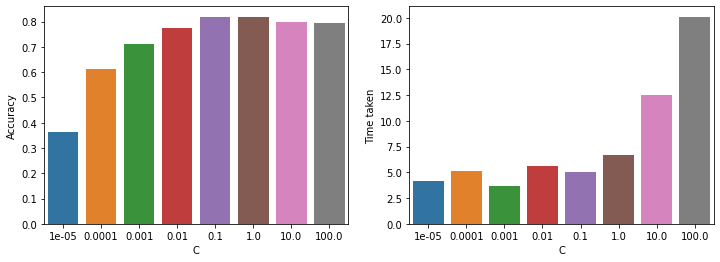

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=c_values, y=scores, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=c_values, y=times, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("Time taken")
plt.show()

We note that our result for the optimal value of C differs from that when using Bag of Words, with the best value being 0.1 to 1.0, separated by a thin margin instead. In fact, while the Bag of Words model had relatively consistent performance regardless of the value of C when varied in this range, the TF-IDF model favors the higher values of C quite heavily, with the lower values having significantly lower accuracies, with 0.00001 only having about 0.33 and 0.0001 about 0.61. 

For our best value, we choose 0.1 as the computation time is lower while having similar accuracy.

In [ ]:
results[2][1] = scores[4]

## SVM with Bag Of Words + Truncated SVD



For models that utilize the Truncated SVD, there are now two dimensions to vary, that being the number of components for the Truncated SVD dimensionality reduction as well as the C value for the SVM. We vary the former from 50 to 250 with steps of 50, and the latter simply between 0.1, 1 and 10.

In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_bag, data['type'])
scores = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
times = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
k_values = range(50, 251, 50)
c_values = [0.1, 1, 10]

for i in range(5):
  k = k_values[i]
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  
  for j in range(3):
    c = c_values[j]
    start_time = time.time()
    svc = SVC(C=c, class_weight='balanced')
    svc.fit(x_train, y_train)
    print(f'C: {c}, k: {k}')
    score = svc.score(x_test, y_test)
    scores[i][j] = score
    print(score)
    y_pred = svc.predict(x_test)
    print(classification_report(y_test, y_pred))
    times[i][j] = time.time() - start_time

C: 0.1, k: 50
0.47308599613982416
              precision    recall  f1-score   support

        ENFJ       0.42      0.38      0.40       311
        ENFP       0.56      0.48      0.52       403
        ENTJ       0.48      0.49      0.48       395
        ENTP       0.77      0.45      0.57       430
        ESFJ       0.11      0.55      0.19        42
        ESFP       0.13      0.49      0.21        71
        ESTJ       0.92      0.68      0.78       106
        ESTP       0.81      0.80      0.81       396
        INFJ       0.54      0.46      0.50       411
        INFP       0.48      0.46      0.47       378
        INTJ       0.44      0.40      0.42       367
        INTP       0.47      0.51      0.49       407
        ISFJ       0.19      0.21      0.20       120
        ISFP       0.30      0.26      0.28       167
        ISTJ       0.31      0.40      0.35       247
        ISTP       0.48      0.42      0.45       412

    accuracy                           0.47   

In [ ]:
svm_df = pd.DataFrame(scores, index=k_values, columns=c_values)
svm_df

,0.1,1.0,10.0
50,0.473086,0.519408,0.521553
100,0.633498,0.694403,0.706198
150,0.674459,0.729573,0.734720
200,0.686897,0.747373,0.744799
250,0.689899,0.752091,0.748231


In [ ]:
time_df = pd.DataFrame(times, index=k_values, columns=c_values)
time_df

,0.1,1.0,10.0
50,89.926770,47.826646,43.940855
100,88.179395,53.787473,44.769815
150,100.448288,58.787753,49.526291
200,122.677122,74.726892,64.276075
250,142.442229,87.464606,77.987118


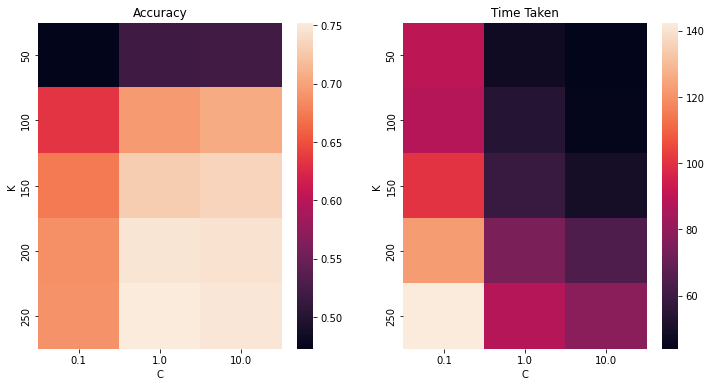

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(svm_df, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("K")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(time_df, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("K")
ax2.set_title("Time Taken")

plt.show()

We observe that accuracy increases as K increases, which makes sense, although there is the trade-off of increasing computation time. We opt for the values K = 250 and C = 1.0, as these yield the best accuracy while having a still-reasonable computation time.

In [ ]:
results[3][0] = svm_df.loc[250, 1.0]

## SVM with TF-IDF + Resampling + Truncated SVD

In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])
scores = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
times = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
k_values = range(50, 251, 50)
c_values = [0.1, 1, 10]

for i in range(5):
  k = k_values[i]
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  
  for j in range(3):
    c = c_values[j]
    start_time = time.time()
    svc = SVC(C=c, class_weight='balanced')
    svc.fit(x_train, y_train)
    print(f'C: {c}, k: {k}')
    score = svc.score(x_test, y_test)
    print(score)
    scores[i][j] = score
    y_pred = svc.predict(x_test)
    print(classification_report(y_test, y_pred))
    times[i][j] = time.time() - start_time

C: 0.1, k: 50
0.762813639288012
              precision    recall  f1-score   support

        ENFJ       0.81      0.76      0.78       311
        ENFP       0.86      0.73      0.79       403
        ENTJ       0.90      0.81      0.85       395
        ENTP       0.83      0.70      0.76       430
        ESFJ       0.37      0.67      0.47        42
        ESFP       0.39      0.62      0.48        71
        ESTJ       0.92      0.81      0.86       106
        ESTP       0.94      0.91      0.92       396
        INFJ       0.72      0.70      0.71       411
        INFP       0.71      0.73      0.72       378
        INTJ       0.64      0.71      0.67       367
        INTP       0.65      0.75      0.70       407
        ISFJ       0.62      0.78      0.69       120
        ISFP       0.65      0.76      0.70       167
        ISTJ       0.78      0.83      0.80       247
        ISTP       0.89      0.80      0.85       412

    accuracy                           0.76     

In [ ]:
svm_df = pd.DataFrame(scores, index=k_values, columns=c_values)
svm_df

,0.1,1.0,10.0
50,0.762814,0.783401,0.786618
100,0.778254,0.793481,0.792408
150,0.781042,0.796054,0.797126
200,0.779327,0.796268,0.800772
250,0.778469,0.800129,0.793910


In [ ]:
time_df = pd.DataFrame(times, index=k_values, columns=c_values)
time_df

,0.1,1.0,10.0
50,44.405673,25.864004,21.250280
100,69.885999,38.510576,33.663515
150,95.954301,49.268028,44.694761
200,122.535495,73.275134,67.027847
250,135.886431,82.469332,80.707310


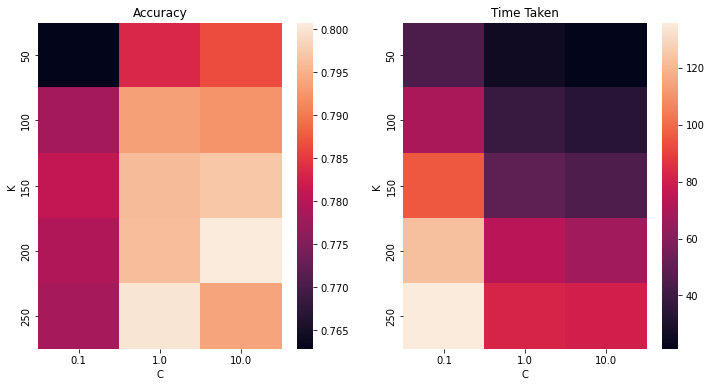

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(svm_df, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("K")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(time_df, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("K")
ax2.set_title("Time Taken")

plt.show()

The optimal value of C is still 1.0. However, the accuracies for K = 100 to K = 250 are all quite high. We thus choose to take K = 100 to reduce the computation time.

In [ ]:
results[3][1] = svm_df.loc[100, 1.0]

## LinearSVC with Bag Of Words + Resampling + Truncated SVD



In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_bag, data['type'])
scores = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
times = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
k_values = range(50, 251, 50)
c_values = [0.0001, 0.1, 1, 10]

for i in range(5):
  k = k_values[i]
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  
  for j in range(4):
    c = c_values[j]
    start_time = time.time()
    svc = LinearSVC(C=c, class_weight='balanced')
    svc.fit(x_train, y_train)
    print(f'C: {c}, k: {k}')
    score = svc.score(x_test, y_test)
    scores[i][j] = score
    print(score)
    y_pred = svc.predict(x_test)
    print(classification_report(y_test, y_pred))
    times[i][j] = time.time() - start_time

C: 0.0001, k: 50
0.45421402530559724
              precision    recall  f1-score   support

        ENFJ       0.38      0.29      0.33       311
        ENFP       0.51      0.67      0.58       403
        ENTJ       0.49      0.54      0.51       395
        ENTP       0.55      0.11      0.19       430
        ESFJ       0.08      0.40      0.13        42
        ESFP       0.12      0.31      0.18        71
        ESTJ       0.83      0.70      0.76       106
        ESTP       0.63      0.89      0.74       396
        INFJ       0.48      0.46      0.47       411
        INFP       0.48      0.46      0.47       378
        INTJ       0.46      0.30      0.36       367
        INTP       0.45      0.46      0.45       407
        ISFJ       0.21      0.22      0.22       120
        ISFP       0.28      0.31      0.29       167
        ISTJ       0.34      0.36      0.35       247
        ISTP       0.56      0.51      0.53       412

    accuracy                           0.45

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 0.1, k: 50
0.48059189363070987
              precision    recall  f1-score   support

        ENFJ       0.42      0.34      0.37       311
        ENFP       0.52      0.67      0.59       403
        ENTJ       0.50      0.56      0.53       395
        ENTP       0.56      0.16      0.24       430
        ESFJ       0.18      0.31      0.23        42
        ESFP       0.17      0.27      0.21        71
        ESTJ       0.77      0.76      0.77       106
        ESTP       0.71      0.88      0.78       396
        INFJ       0.47      0.51      0.49       411
        INFP       0.49      0.47      0.48       378
        INTJ       0.45      0.32      0.37       367
        INTP       0.45      0.49      0.47       407
        ISFJ       0.19      0.22      0.20       120
        ISFP       0.28      0.37      0.32       167
        ISTJ       0.35      0.39      0.37       247
        ISTP       0.55      0.56      0.56       412

    accuracy                           0.48   

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 1, k: 50
0.38944885266995494
              precision    recall  f1-score   support

        ENFJ       0.43      0.18      0.25       311
        ENFP       0.68      0.40      0.51       403
        ENTJ       0.52      0.51      0.51       395
        ENTP       0.39      0.16      0.23       430
        ESFJ       0.00      0.00      0.00        42
        ESFP       0.12      0.08      0.10        71
        ESTJ       0.84      0.66      0.74       106
        ESTP       0.83      0.82      0.83       396
        INFJ       0.44      0.38      0.41       411
        INFP       0.58      0.38      0.46       378
        INTJ       0.39      0.20      0.26       367
        INTP       0.35      0.61      0.45       407
        ISFJ       0.23      0.03      0.05       120
        ISFP       0.33      0.01      0.02       167
        ISTJ       0.13      0.79      0.22       247
        ISTP       0.65      0.26      0.37       412

    accuracy                           0.39     

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `

C: 10, k: 50
0.21574093930945742
              precision    recall  f1-score   support

        ENFJ       0.60      0.02      0.04       311
        ENFP       0.60      0.07      0.13       403
        ENTJ       0.61      0.13      0.21       395
        ENTP       0.11      0.96      0.20       430
        ESFJ       0.00      0.00      0.00        42
        ESFP       0.11      0.01      0.03        71
        ESTJ       0.87      0.65      0.75       106
        ESTP       0.78      0.72      0.75       396
        INFJ       0.54      0.11      0.18       411
        INFP       0.86      0.06      0.12       378
        INTJ       0.31      0.02      0.04       367
        INTP       0.31      0.08      0.12       407
        ISFJ       0.16      0.05      0.08       120
        ISFP       0.17      0.01      0.01       167
        ISTJ       0.50      0.07      0.13       247
        ISTP       0.72      0.04      0.08       412

    accuracy                           0.22    

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 0.1, k: 100
0.7141325327042677
              precision    recall  f1-score   support

        ENFJ       0.63      0.52      0.57       311
        ENFP       0.73      0.80      0.76       403
        ENTJ       0.84      0.82      0.83       395
        ENTP       0.74      0.68      0.71       430
        ESFJ       0.33      0.31      0.32        42
        ESFP       0.25      0.32      0.28        71
        ESTJ       0.82      0.75      0.78       106
        ESTP       0.85      0.91      0.88       396
        INFJ       0.72      0.69      0.70       411
        INFP       0.70      0.72      0.71       378
        INTJ       0.71      0.69      0.70       367
        INTP       0.69      0.72      0.70       407
        ISFJ       0.48      0.52      0.50       120
        ISFP       0.55      0.56      0.55       167
        ISTJ       0.65      0.73      0.68       247
        ISTP       0.83      0.76      0.79       412

    accuracy                           0.71   

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 1, k: 100
0.6304953892343984


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


              precision    recall  f1-score   support

        ENFJ       0.51      0.53      0.52       311
        ENFP       0.78      0.70      0.74       403
        ENTJ       0.78      0.78      0.78       395
        ENTP       0.53      0.77      0.63       430
        ESFJ       0.56      0.12      0.20        42
        ESFP       0.29      0.32      0.31        71
        ESTJ       0.80      0.73      0.76       106
        ESTP       0.83      0.91      0.87       396
        INFJ       0.64      0.71      0.67       411
        INFP       0.40      0.84      0.54       378
        INTJ       0.95      0.22      0.35       367
        INTP       0.80      0.39      0.52       407
        ISFJ       0.37      0.51      0.43       120
        ISFP       0.77      0.22      0.34       167
        ISTJ       0.61      0.55      0.58       247
        ISTP       0.79      0.75      0.77       412

    accuracy                           0.63      4663
   macro avg       0.65   

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 0.1, k: 150
0.7458717563800129
              precision    recall  f1-score   support

        ENFJ       0.72      0.69      0.71       311
        ENFP       0.77      0.78      0.78       403
        ENTJ       0.84      0.82      0.83       395
        ENTP       0.75      0.71      0.73       430
        ESFJ       0.37      0.50      0.42        42
        ESFP       0.37      0.48      0.42        71
        ESTJ       0.82      0.75      0.79       106
        ESTP       0.89      0.91      0.90       396
        INFJ       0.76      0.71      0.73       411
        INFP       0.70      0.72      0.71       378
        INTJ       0.75      0.68      0.71       367
        INTP       0.72      0.73      0.73       407
        ISFJ       0.56      0.65      0.60       120
        ISFP       0.63      0.69      0.66       167
        ISTJ       0.67      0.80      0.73       247
        ISTP       0.86      0.79      0.82       412

    accuracy                           0.75   

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 1, k: 150
0.687754664379155
              precision    recall  f1-score   support

        ENFJ       0.80      0.57      0.66       311
        ENFP       0.79      0.73      0.76       403
        ENTJ       0.67      0.87      0.75       395
        ENTP       0.83      0.51      0.63       430
        ESFJ       0.47      0.33      0.39        42
        ESFP       0.61      0.32      0.42        71
        ESTJ       0.86      0.78      0.82       106
        ESTP       0.81      0.91      0.86       396
        INFJ       0.75      0.64      0.69       411
        INFP       0.69      0.68      0.68       378
        INTJ       0.53      0.74      0.62       367
        INTP       0.64      0.70      0.67       407
        ISFJ       0.61      0.47      0.54       120
        ISFP       0.60      0.60      0.60       167
        ISTJ       0.89      0.43      0.58       247
        ISTP       0.57      0.87      0.69       412

    accuracy                           0.69      

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 10, k: 150
0.5762384730859962
              precision    recall  f1-score   support

        ENFJ       0.81      0.54      0.65       311
        ENFP       0.81      0.63      0.71       403
        ENTJ       0.87      0.65      0.74       395
        ENTP       0.63      0.66      0.64       430
        ESFJ       0.67      0.10      0.17        42
        ESFP       0.12      0.65      0.21        71
        ESTJ       0.76      0.70      0.73       106
        ESTP       0.97      0.73      0.83       396
        INFJ       0.77      0.53      0.63       411
        INFP       0.66      0.60      0.63       378
        INTJ       0.87      0.13      0.23       367
        INTP       0.62      0.50      0.55       407
        ISFJ       0.75      0.25      0.38       120
        ISFP       0.82      0.16      0.27       167
        ISTJ       0.54      0.71      0.61       247
        ISTP       0.32      0.94      0.48       412

    accuracy                           0.58    

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 0.1, k: 200
0.7563800128672529
              precision    recall  f1-score   support

        ENFJ       0.75      0.73      0.74       311
        ENFP       0.76      0.81      0.78       403
        ENTJ       0.84      0.80      0.82       395
        ENTP       0.75      0.71      0.73       430
        ESFJ       0.43      0.45      0.44        42
        ESFP       0.38      0.51      0.43        71
        ESTJ       0.78      0.80      0.79       106
        ESTP       0.92      0.92      0.92       396
        INFJ       0.76      0.70      0.73       411
        INFP       0.69      0.74      0.71       378
        INTJ       0.74      0.69      0.72       367
        INTP       0.74      0.71      0.72       407
        ISFJ       0.59      0.73      0.65       120
        ISFP       0.68      0.72      0.70       167
        ISTJ       0.71      0.79      0.75       247
        ISTP       0.87      0.81      0.84       412

    accuracy                           0.76   

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 1, k: 200
0.7173493459146473


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


              precision    recall  f1-score   support

        ENFJ       0.90      0.55      0.68       311
        ENFP       0.76      0.76      0.76       403
        ENTJ       0.75      0.81      0.78       395
        ENTP       0.84      0.62      0.72       430
        ESFJ       0.36      0.36      0.36        42
        ESFP       0.72      0.32      0.45        71
        ESTJ       0.70      0.81      0.75       106
        ESTP       0.85      0.93      0.89       396
        INFJ       0.60      0.74      0.67       411
        INFP       0.66      0.70      0.68       378
        INTJ       0.79      0.57      0.66       367
        INTP       0.57      0.81      0.67       407
        ISFJ       0.55      0.68      0.61       120
        ISFP       0.84      0.60      0.70       167
        ISTJ       0.58      0.80      0.67       247
        ISTP       0.88      0.74      0.80       412

    accuracy                           0.72      4663
   macro avg       0.71   

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 0.1, k: 250
0.7587390092215313
              precision    recall  f1-score   support

        ENFJ       0.78      0.73      0.76       311
        ENFP       0.77      0.80      0.79       403
        ENTJ       0.83      0.82      0.82       395
        ENTP       0.76      0.71      0.73       430
        ESFJ       0.42      0.60      0.50        42
        ESFP       0.52      0.58      0.55        71
        ESTJ       0.77      0.81      0.79       106
        ESTP       0.93      0.92      0.92       396
        INFJ       0.75      0.71      0.73       411
        INFP       0.70      0.73      0.72       378
        INTJ       0.75      0.68      0.72       367
        INTP       0.70      0.72      0.71       407
        ISFJ       0.63      0.72      0.67       120
        ISFP       0.64      0.71      0.67       167
        ISTJ       0.71      0.80      0.75       247
        ISTP       0.86      0.80      0.83       412

    accuracy                           0.76   

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 1, k: 250
0.7094145399957109
              precision    recall  f1-score   support

        ENFJ       0.71      0.73      0.72       311
        ENFP       0.78      0.75      0.76       403
        ENTJ       0.77      0.82      0.79       395
        ENTP       0.73      0.69      0.71       430
        ESFJ       0.48      0.69      0.57        42
        ESFP       0.76      0.31      0.44        71
        ESTJ       0.87      0.75      0.81       106
        ESTP       0.94      0.92      0.93       396
        INFJ       0.77      0.59      0.67       411
        INFP       0.81      0.50      0.62       378
        INTJ       0.84      0.51      0.64       367
        INTP       0.57      0.78      0.66       407
        ISFJ       0.62      0.68      0.65       120
        ISFP       0.57      0.69      0.63       167
        ISTJ       0.41      0.91      0.57       247
        ISTP       0.87      0.74      0.80       412

    accuracy                           0.71     

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 10, k: 250
0.6791764958181429
              precision    recall  f1-score   support

        ENFJ       0.73      0.68      0.71       311
        ENFP       0.57      0.81      0.67       403
        ENTJ       0.81      0.73      0.77       395
        ENTP       0.60      0.75      0.66       430
        ESFJ       0.55      0.52      0.54        42
        ESFP       0.46      0.44      0.45        71
        ESTJ       0.74      0.75      0.74       106
        ESTP       0.81      0.94      0.87       396
        INFJ       0.79      0.44      0.57       411
        INFP       0.80      0.43      0.56       378
        INTJ       0.65      0.57      0.61       367
        INTP       0.51      0.74      0.61       407
        ISFJ       0.67      0.68      0.67       120
        ISFP       0.60      0.66      0.63       167
        ISTJ       0.68      0.69      0.69       247
        ISTP       0.89      0.72      0.80       412

    accuracy                           0.68    

In [ ]:
svc_df = pd.DataFrame(scores, index=k_values, columns=c_values)
svc_df

,0.0001,0.1000,1.0000,10.0000
50,0.454214,0.480592,0.389449,0.215741
100,0.698477,0.714133,0.630495,0.514905
150,0.738151,0.745872,0.687755,0.576238
200,0.752949,0.756380,0.717349,0.679391
250,0.756809,0.758739,0.709415,0.679176


In [ ]:
time_df = pd.DataFrame(times, index=k_values, columns=c_values)
time_df

,0.0001,0.1000,1.0000,10.0000
50,5.608668,76.503637,115.740102,114.744744
100,6.329460,78.154814,133.777117,138.442803
150,7.859700,101.704083,165.992765,186.166723
200,9.733735,121.255690,202.358462,220.832151
250,11.929833,119.944193,200.431354,217.612394


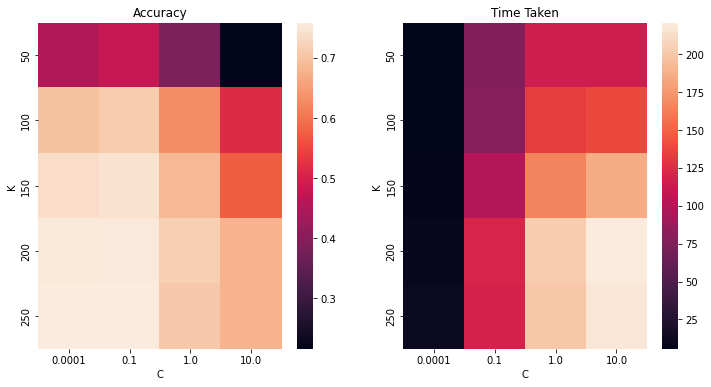

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(svc_df, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("K")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(time_df, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("K")
ax2.set_title("Time Taken")

plt.show()

For this particular section, we have added the C value of 0.001, as it was the optimal value when we tested the LinearSVC without dimensionality reduction. 0.001 remains the optimal value of C, with K = 250 giving the highest accuracy out of the five values. However, the accuracy values of 0.76 yielded by these are still quite a step below the 0.80 of the LinearSVC without any dimensionality reduction. This is compensated by the version with Truncated SVD running in approximately half the time. However, the original LinearSVC ran within a reasonable amount of time, so this concession in accuracy for the sake of speed is not necessary.

In [ ]:
results[4][0] = svc_df.loc[250, 0.0001]

## LinearSVC with TF-IDF + Resampling + Truncated SVD

In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])
scores = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
times = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
k_values = range(50, 251, 50)
c_values = [0.1, 1, 10]

for i in range(5):
  k = k_values[i]
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  
  for j in range(3):
    c = c_values[j]
    start_time = time.time()
    svc = LinearSVC(C=c, class_weight='balanced')
    svc.fit(x_train, y_train)
    print(f'C: {c}, k: {k}')
    score = svc.score(x_test, y_test)
    scores[i][j] = score
    print(score)
    y_pred = svc.predict(x_test)
    print(classification_report(y_test, y_pred))
    times[i][j] = time.time() - start_time

C: 0.1, k: 50
0.7816856101222389
              precision    recall  f1-score   support

        ENFJ       0.78      0.73      0.75       311
        ENFP       0.80      0.82      0.81       403
        ENTJ       0.87      0.84      0.86       395
        ENTP       0.80      0.73      0.76       430
        ESFJ       0.51      0.81      0.62        42
        ESFP       0.44      0.65      0.53        71
        ESTJ       0.87      0.85      0.86       106
        ESTP       0.89      0.94      0.92       396
        INFJ       0.76      0.74      0.75       411
        INFP       0.78      0.74      0.76       378
        INTJ       0.74      0.68      0.70       367
        INTP       0.76      0.73      0.75       407
        ISFJ       0.62      0.79      0.70       120
        ISFP       0.69      0.77      0.73       167
        ISTJ       0.74      0.86      0.79       247
        ISTP       0.87      0.82      0.84       412

    accuracy                           0.78    

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 10, k: 50
0.7926227750375295
              precision    recall  f1-score   support

        ENFJ       0.77      0.74      0.75       311
        ENFP       0.81      0.82      0.81       403
        ENTJ       0.87      0.85      0.86       395
        ENTP       0.79      0.73      0.76       430
        ESFJ       0.56      0.81      0.66        42
        ESFP       0.47      0.68      0.55        71
        ESTJ       0.82      0.89      0.85       106
        ESTP       0.94      0.94      0.94       396
        INFJ       0.77      0.75      0.76       411
        INFP       0.80      0.76      0.78       378
        INTJ       0.73      0.72      0.72       367
        INTP       0.77      0.75      0.76       407
        ISFJ       0.67      0.78      0.72       120
        ISFP       0.70      0.76      0.73       167
        ISTJ       0.77      0.85      0.81       247
        ISTP       0.87      0.83      0.85       412

    accuracy                           0.79     

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 10, k: 100
0.8031310315247695
              precision    recall  f1-score   support

        ENFJ       0.77      0.75      0.76       311
        ENFP       0.83      0.81      0.82       403
        ENTJ       0.87      0.84      0.85       395
        ENTP       0.80      0.75      0.77       430
        ESFJ       0.59      0.79      0.67        42
        ESFP       0.55      0.73      0.63        71
        ESTJ       0.76      0.92      0.83       106
        ESTP       0.95      0.95      0.95       396
        INFJ       0.78      0.74      0.76       411
        INFP       0.80      0.78      0.79       378
        INTJ       0.76      0.73      0.75       367
        INTP       0.77      0.78      0.78       407
        ISFJ       0.68      0.78      0.73       120
        ISFP       0.70      0.81      0.75       167
        ISTJ       0.76      0.84      0.80       247
        ISTP       0.90      0.85      0.88       412

    accuracy                           0.80    

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 10, k: 150
0.8063478447351491
              precision    recall  f1-score   support

        ENFJ       0.78      0.78      0.78       311
        ENFP       0.84      0.81      0.82       403
        ENTJ       0.88      0.84      0.86       395
        ENTP       0.80      0.75      0.77       430
        ESFJ       0.61      0.79      0.69        42
        ESFP       0.55      0.76      0.64        71
        ESTJ       0.78      0.92      0.84       106
        ESTP       0.95      0.94      0.95       396
        INFJ       0.79      0.72      0.75       411
        INFP       0.79      0.77      0.78       378
        INTJ       0.75      0.77      0.76       367
        INTP       0.78      0.79      0.78       407
        ISFJ       0.73      0.79      0.76       120
        ISFP       0.71      0.80      0.75       167
        ISTJ       0.77      0.85      0.81       247
        ISTP       0.89      0.86      0.88       412

    accuracy                           0.81    

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 10, k: 200
0.8050611194509972
              precision    recall  f1-score   support

        ENFJ       0.79      0.77      0.78       311
        ENFP       0.84      0.80      0.82       403
        ENTJ       0.89      0.85      0.87       395
        ENTP       0.83      0.76      0.79       430
        ESFJ       0.63      0.69      0.66        42
        ESFP       0.62      0.82      0.70        71
        ESTJ       0.77      0.92      0.84       106
        ESTP       0.94      0.95      0.95       396
        INFJ       0.77      0.72      0.74       411
        INFP       0.78      0.77      0.77       378
        INTJ       0.75      0.76      0.76       367
        INTP       0.78      0.76      0.77       407
        ISFJ       0.67      0.82      0.74       120
        ISFP       0.71      0.78      0.74       167
        ISTJ       0.76      0.85      0.80       247
        ISTP       0.88      0.86      0.87       412

    accuracy                           0.81    

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


C: 10, k: 250
0.8078490242333262
              precision    recall  f1-score   support

        ENFJ       0.80      0.78      0.79       311
        ENFP       0.83      0.80      0.82       403
        ENTJ       0.89      0.86      0.88       395
        ENTP       0.82      0.76      0.79       430
        ESFJ       0.65      0.79      0.71        42
        ESFP       0.60      0.79      0.68        71
        ESTJ       0.74      0.92      0.82       106
        ESTP       0.94      0.95      0.95       396
        INFJ       0.77      0.73      0.74       411
        INFP       0.79      0.77      0.78       378
        INTJ       0.77      0.75      0.76       367
        INTP       0.77      0.77      0.77       407
        ISFJ       0.68      0.78      0.72       120
        ISFP       0.73      0.78      0.76       167
        ISTJ       0.78      0.86      0.82       247
        ISTP       0.88      0.86      0.87       412

    accuracy                           0.81    

In [ ]:
svc_df = pd.DataFrame(scores, index=k_values, columns=c_values)
svc_df

,0.1,1.0,10.0
50,0.781686,0.789620,0.792623
100,0.799056,0.804203,0.803131
150,0.802488,0.806133,0.806348
200,0.802273,0.810851,0.805061
250,0.807420,0.808278,0.807849


In [ ]:
time_df = pd.DataFrame(times, index=k_values, columns=c_values)
time_df

,0.1,1.0,10.0
50,1.072711,1.762679,9.871479
100,1.870319,3.360535,17.626216
150,2.615802,4.612143,25.577209
200,2.973675,5.408876,27.833997
250,3.595030,6.330445,33.678463


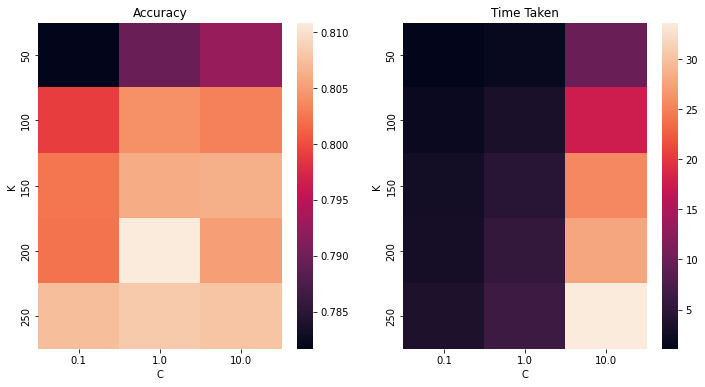

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(svc_df, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("K")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(time_df, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("K")
ax2.set_title("Time Taken")

plt.show()

TF-IDF yields much faster execution times and better accuracies than Bag of Words. The optimal value yields K = 200 and C = 1.0, with an accuracy of 0.81, slightly lower than the 0.81 to 0.82 without dimensionality reduction. This is not too harsh of a drop, but the reduction in time taken for C = 1.0 is marginal.

It is worth noting, however, that the optimal value of C seems to have changed when TruncatedSVD is used, with 1.0 performing better than the previously optimal 0.1. 0.1 also saw much larger benefits in terms of reduction in computation time. However, both models ran very quickly without dimensionality reduction to begin with, so Truncated SVD is likely unnecessary. Still, we add this result to our list.

In [ ]:
results[4][1] = svc_df.loc[200, 1.0]

## Logistic Regression with Bag Of Words + Resampling + Truncated SVD

As before, we analyse the values of K to see which one gives optimal performance.

In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_bag, data['type'])

scores = []
times = []
k_val = []

for k in range(50, 251, 50):
  start_time = time.time()
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)

  smote = SMOTE()
  x_r, y_r = smote.fit_resample(x_train, y_train)
  
  lr = LogisticRegression()
  lr.fit(x_r, y_r)
  print(k)
  score = lr.score(x_test, y_test)
  print(score)
  y_pred = lr.predict(x_test)
  print(classification_report(y_test, y_pred))

  k_val.append(k)
  scores.append(score)
  times.append(time.time() - start_time)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


50
0.4904567874758739
              precision    recall  f1-score   support

        ENFJ       0.42      0.37      0.40       311
        ENFP       0.56      0.54      0.55       403
        ENTJ       0.63      0.60      0.61       395
        ENTP       0.51      0.38      0.44       430
        ESFJ       0.13      0.45      0.20        42
        ESFP       0.17      0.38      0.23        71
        ESTJ       0.81      0.76      0.79       106
        ESTP       0.77      0.79      0.78       396
        INFJ       0.50      0.48      0.49       411
        INFP       0.46      0.41      0.43       378
        INTJ       0.45      0.48      0.47       367
        INTP       0.48      0.46      0.47       407
        ISFJ       0.27      0.36      0.31       120
        ISFP       0.31      0.34      0.32       167
        ISTJ       0.44      0.48      0.46       247
        ISTP       0.49      0.43      0.46       412

    accuracy                           0.49      4663
   m

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


100
0.7051254557152048
              precision    recall  f1-score   support

        ENFJ       0.65      0.60      0.62       311
        ENFP       0.78      0.74      0.76       403
        ENTJ       0.83      0.79      0.81       395
        ENTP       0.74      0.67      0.70       430
        ESFJ       0.24      0.60      0.34        42
        ESFP       0.29      0.45      0.36        71
        ESTJ       0.79      0.78      0.79       106
        ESTP       0.91      0.86      0.89       396
        INFJ       0.72      0.68      0.70       411
        INFP       0.70      0.66      0.68       378
        INTJ       0.66      0.71      0.68       367
        INTP       0.73      0.70      0.71       407
        ISFJ       0.44      0.59      0.50       120
        ISFP       0.54      0.58      0.56       167
        ISTJ       0.65      0.70      0.67       247
        ISTP       0.78      0.74      0.76       412

    accuracy                           0.71      4663
   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


150
0.7259275144756594
              precision    recall  f1-score   support

        ENFJ       0.70      0.68      0.69       311
        ENFP       0.77      0.74      0.76       403
        ENTJ       0.85      0.79      0.82       395
        ENTP       0.74      0.71      0.72       430
        ESFJ       0.23      0.50      0.32        42
        ESFP       0.39      0.56      0.46        71
        ESTJ       0.81      0.84      0.82       106
        ESTP       0.93      0.87      0.90       396
        INFJ       0.72      0.66      0.69       411
        INFP       0.68      0.65      0.66       378
        INTJ       0.67      0.72      0.69       367
        INTP       0.70      0.69      0.69       407
        ISFJ       0.55      0.65      0.60       120
        ISFP       0.63      0.71      0.67       167
        ISTJ       0.70      0.76      0.73       247
        ISTP       0.82      0.76      0.79       412

    accuracy                           0.73      4663
   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


200
0.7323611408964186
              precision    recall  f1-score   support

        ENFJ       0.76      0.72      0.74       311
        ENFP       0.77      0.73      0.75       403
        ENTJ       0.85      0.79      0.82       395
        ENTP       0.72      0.71      0.72       430
        ESFJ       0.29      0.55      0.38        42
        ESFP       0.40      0.55      0.46        71
        ESTJ       0.78      0.83      0.80       106
        ESTP       0.92      0.89      0.90       396
        INFJ       0.70      0.70      0.70       411
        INFP       0.69      0.63      0.66       378
        INTJ       0.66      0.70      0.68       367
        INTP       0.70      0.70      0.70       407
        ISFJ       0.63      0.71      0.67       120
        ISFP       0.64      0.72      0.68       167
        ISTJ       0.72      0.74      0.73       247
        ISTP       0.82      0.78      0.80       412

    accuracy                           0.73      4663
   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
scores

[0.4904567874758739,
 0.7051254557152048,
 0.7259275144756594,
 0.7323611408964186,
 0.7392236757452284]

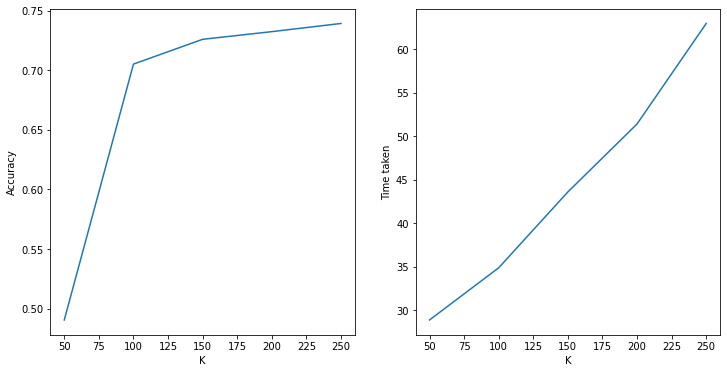

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.lineplot(x=k_val, y=scores, ax=ax1)
ax1.set_xlabel("K")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.lineplot(x=k_val, y=times, ax=ax2)
ax2.set_xlabel("K")
ax2.set_ylabel("Time taken") 
plt.show()

The score increases with the value of K, as does the time taken. However, the effect of increasing K on accuracy quickly diminishes, whereas the effect of increasing K on time taken increases as K increases. Thus, we take K = 200, as the gains after that are <1%.

In [ ]:
results[5][0] = scores[3]

## Logistic Regression with TF-IDF + Resampling + Truncated SVD

In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])

scores = []
k_val = []
times = []

for k in range(50, 251, 50):
  start_time = time.time()
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)

  smote = SMOTE()
  x_r, y_r = smote.fit_resample(x_train, y_train)
  
  lr = LogisticRegression(max_iter = 200)
  lr.fit(x_r, y_r)
  print(k)
  score = lr.score(x_test, y_test)
  print(score)
  y_pred = lr.predict(x_test)
  print(classification_report(y_test, y_pred))

  k_val.append(k)
  scores.append(score)
  times.append(time.time() - start_time)

50
0.778254342697834
              precision    recall  f1-score   support

        ENFJ       0.83      0.72      0.77       311
        ENFP       0.85      0.83      0.84       403
        ENTJ       0.89      0.82      0.85       395
        ENTP       0.80      0.72      0.76       430
        ESFJ       0.38      0.67      0.49        42
        ESFP       0.43      0.77      0.55        71
        ESTJ       0.86      0.77      0.82       106
        ESTP       0.91      0.92      0.91       396
        INFJ       0.77      0.74      0.75       411
        INFP       0.74      0.72      0.73       378
        INTJ       0.70      0.76      0.73       367
        INTP       0.68      0.74      0.71       407
        ISFJ       0.68      0.78      0.73       120
        ISFP       0.75      0.75      0.75       167
        ISTJ       0.76      0.81      0.79       247
        ISTP       0.88      0.82      0.85       412

    accuracy                           0.78      4663
   ma

In [ ]:
scores

[0.778254342697834,
 0.7960540424619343,
 0.8027021230967188,
 0.802058760454643,
 0.8054900278790478]

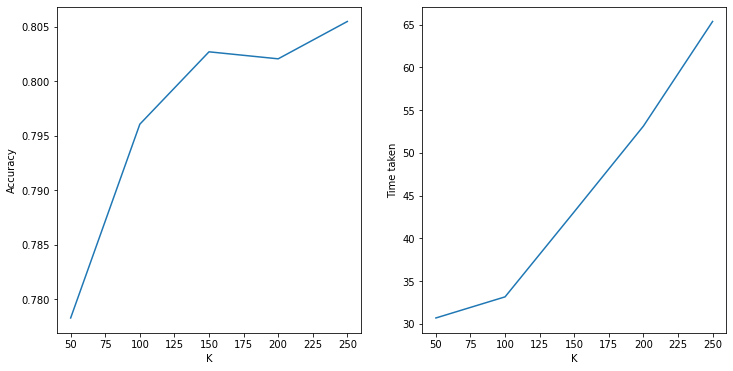

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.lineplot(x=k_val, y=scores, ax=ax1)
ax1.set_xlabel("K")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.lineplot(x=k_val, y=times, ax=ax2)
ax2.set_xlabel("K")
ax2.set_ylabel("Time taken") 
plt.show()

The accuracy values, particularly those corresponding to K = 150 and above, are extremely close, making further increases no longer worth the runtime increase. Hence, we take the peak at K = 150.

In [ ]:
results[5][1] = scores[2]

## Random Forest with Bag of Words + Resampling + Truncated SVD

In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_bag, data['type'])

scores = []
k_val = []
times = []

for k in range(50, 251, 50):
  start_time = time.time()
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  
  rf = RandomForestClassifier(class_weight='balanced')
  rf.fit(x_train, y_train)
  print(k)
  score = rf.score(x_test, y_test)
  print(score)
  y_pred = rf.predict(x_test)
  print(classification_report(y_test, y_pred))

  k_val.append(k)
  scores.append(score)
  times.append(time.time() - start_time)

50
0.36500107227107015
              precision    recall  f1-score   support

        ENFJ       0.28      0.26      0.27       311
        ENFP       0.37      0.50      0.42       403
        ENTJ       0.40      0.47      0.43       395
        ENTP       0.27      0.27      0.27       430
        ESFJ       1.00      0.02      0.05        42
        ESFP       0.22      0.06      0.09        71
        ESTJ       0.82      0.65      0.73       106
        ESTP       0.63      0.81      0.71       396
        INFJ       0.33      0.42      0.37       411
        INFP       0.28      0.34      0.31       378
        INTJ       0.30      0.34      0.32       367
        INTP       0.32      0.27      0.30       407
        ISFJ       0.27      0.05      0.08       120
        ISFP       0.30      0.22      0.25       167
        ISTJ       0.34      0.11      0.17       247
        ISTP       0.33      0.29      0.31       412

    accuracy                           0.37      4663
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        ENFJ       0.35      0.27      0.30       311
        ENFP       0.50      0.67      0.57       403
        ENTJ       0.58      0.66      0.62       395
        ENTP       0.51      0.53      0.52       430
        ESFJ       0.00      0.00      0.00        42
        ESFP       0.40      0.03      0.05        71
        ESTJ       0.89      0.61      0.73       106
        ESTP       0.64      0.82      0.72       396
        INFJ       0.47      0.56      0.51       411
        INFP       0.41      0.50      0.45       378
        INTJ       0.41      0.51      0.46       367
        INTP       0.48      0.48      0.48       407
        ISFJ       0.19      0.03      0.06       120
        ISFP       0.61      0.35      0.44       167
        ISTJ       0.54      0.21      0.30       247
        ISTP       0.57      0.51      0.54       412

    accuracy                           0.51      4663
   macro avg       0.47   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        ENFJ       0.52      0.38      0.44       311
        ENFP       0.47      0.65      0.55       403
        ENTJ       0.56      0.64      0.60       395
        ENTP       0.44      0.45      0.44       430
        ESFJ       0.00      0.00      0.00        42
        ESFP       0.00      0.00      0.00        71
        ESTJ       0.83      0.61      0.71       106
        ESTP       0.64      0.84      0.72       396
        INFJ       0.49      0.57      0.52       411
        INFP       0.38      0.46      0.42       378
        INTJ       0.39      0.48      0.43       367
        INTP       0.43      0.43      0.43       407
        ISFJ       0.74      0.24      0.36       120
        ISFP       0.70      0.35      0.46       167
        ISTJ       0.71      0.23      0.34       247
        ISTP       0.53      0.48      0.51       412

    accuracy                           0.50      4663
   macro avg       0.49   

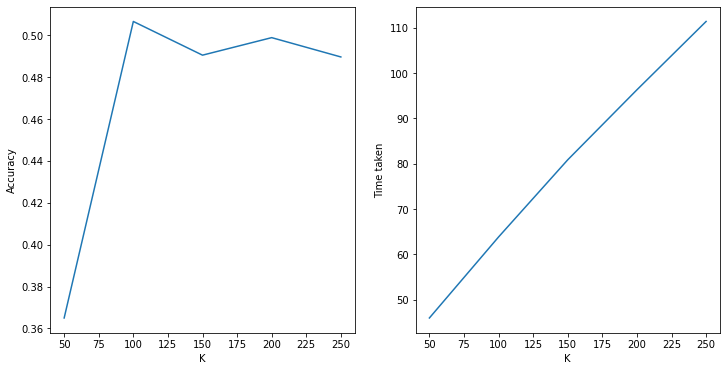

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.lineplot(x=k_val, y=scores, ax=ax1)
ax1.set_xlabel("K")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.lineplot(x=k_val, y=times, ax=ax2)
ax2.set_xlabel("K")
ax2.set_ylabel("Time taken") 
plt.show()

This model performs quite poorly in general. Increasing K tends to reduce the performance quite early, hitting an early peak at K = 100. which is the best value we obtain for this model.

In [ ]:
results[6][0] = scores[1]

## Random Forest with TF-IDF + Resampling + Truncated SVD

In [ ]:
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])

scores = []
k_val = []
times = []

for k in range(50, 251, 50):
  start_time = time.time()
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  
  rf = RandomForestClassifier(class_weight='balanced')
  rf.fit(x_train, y_train)
  print(k)
  score = rf.score(x_test, y_test)
  print(score)
  y_pred = rf.predict(x_test)
  print(classification_report(y_test, y_pred))

  k_val.append(k)
  scores.append(score)
  times.append(time.time() - start_time)

50
0.7252841518335835
              precision    recall  f1-score   support

        ENFJ       0.75      0.71      0.73       311
        ENFP       0.71      0.81      0.76       403
        ENTJ       0.83      0.79      0.81       395
        ENTP       0.70      0.71      0.71       430
        ESFJ       0.76      0.45      0.57        42
        ESFP       0.82      0.46      0.59        71
        ESTJ       0.94      0.84      0.89       106
        ESTP       0.93      0.92      0.93       396
        INFJ       0.64      0.66      0.65       411
        INFP       0.66      0.70      0.68       378
        INTJ       0.55      0.59      0.57       367
        INTP       0.59      0.60      0.59       407
        ISFJ       0.75      0.63      0.69       120
        ISFP       0.73      0.69      0.71       167
        ISTJ       0.76      0.78      0.77       247
        ISTP       0.82      0.80      0.81       412

    accuracy                           0.73      4663
   m

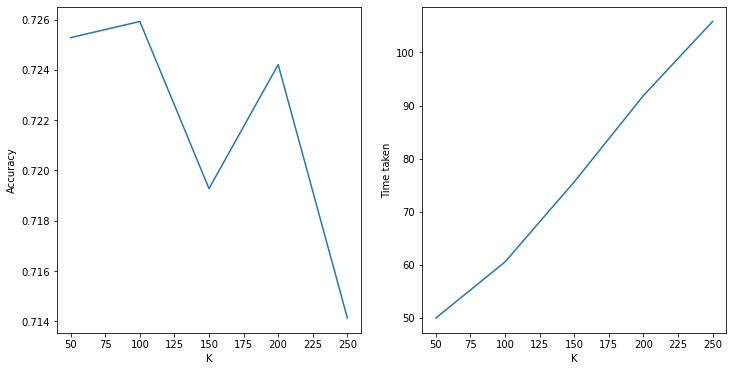

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.lineplot(x=k_val, y=scores, ax=ax1)
ax1.set_xlabel("K")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.lineplot(x=k_val, y=times, ax=ax2)
ax2.set_xlabel("K")
ax2.set_ylabel("Time taken") 
plt.show()

The accuracy here is better than with Bag of Words, but still is quite a bit lower than the other models. Similar to Bag of Words, however, the optimal K value peaks at K = 100, with the performance dropping after that. 

In [ ]:
results[6][1] = scores[1] 

## KNN with Bag of Words + Resampling + TruncatedSVD

KNN algorithm takes in the number of neighbors in addition to the dimension of K for TruncatedSVD. Thus, we perform a 2D analysis similar to that of the LinearSVC models and SVM.

In [ ]:
neighbors_k_values = range(20, 101, 20)
component_k_values = range(50, 251, 50)
scores = []
times = []

for n_components in component_k_values:
  scores.append([])
  times.append([])
  for n_neighbors in neighbors_k_values:
    under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
    x, y = under.fit_resample(x_bag, data['type'])

    svd = TruncatedSVD(n_components = n_components)
    x_t = svd.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)

    smote = SMOTE()
    x_r, y_r = smote.fit_resample(x_train, y_train)

    start_time = time.time()
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(x_r, y_r)
    print(f'n_components: {n_components}, n_neighbors: {n_neighbors}')
    score = knn.score(x_test, y_test)
    print(score)
    scores[-1].append(score)
    y_pred = knn.predict(x_test)
    print(classification_report(y_test, y_pred))
    times[-1].append(time.time() - start_time)


n_components: 50, n_neighbors: 20
0.23461291014368432
              precision    recall  f1-score   support

        ENFJ       0.22      0.25      0.23       311
        ENFP       0.42      0.21      0.28       403
        ENTJ       0.42      0.26      0.32       395
        ENTP       0.22      0.09      0.13       430
        ESFJ       0.03      0.26      0.06        42
        ESFP       0.05      0.49      0.10        71
        ESTJ       0.40      0.66      0.50       106
        ESTP       0.66      0.80      0.72       396
        INFJ       0.31      0.11      0.16       411
        INFP       0.29      0.09      0.14       378
        INTJ       0.28      0.11      0.15       367
        INTP       0.34      0.15      0.21       407
        ISFJ       0.06      0.28      0.10       120
        ISFP       0.11      0.22      0.15       167
        ISTJ       0.15      0.30      0.20       247
        ISTP       0.43      0.08      0.14       412

    accuracy              

In [ ]:
knn_df = pd.DataFrame(scores, index=component_k_values, columns=neighbors_k_values)
knn_df

,20,40,60,80,100
50,0.234613,0.222175,0.238259,0.239974,0.232039
100,0.223461,0.231396,0.245121,0.233541,0.233112
150,0.214025,0.217242,0.209951,0.213596,0.193652
200,0.216813,0.200086,0.199657,0.195797,0.187862
250,0.207806,0.193009,0.197083,0.188076,0.188505


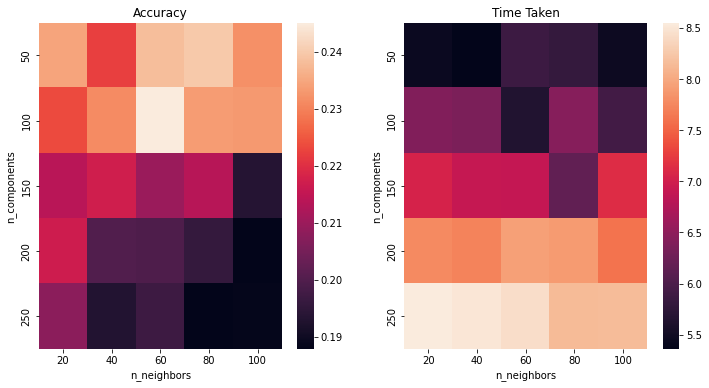

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(knn_df, ax=ax1)
ax1.set_xlabel("n_neighbors")
ax1.set_ylabel("n_components")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(times, index=component_k_values, columns=neighbors_k_values), ax=ax2)
ax2.set_xlabel("n_neighbors")
ax2.set_ylabel("n_components")
ax2.set_title("Time Taken")
plt.show()

The KNN algorithm using Bag of Words performs even worse than the previous Random Forest, achieving a maximum of only 0.25 accuracy, attained when we use 100 components and 60 neighbors. 

In [ ]:
results[7][0] = knn_df.loc[100, 60]

## KNN with TF-IDF + Resampling + TruncatedSVD

In [ ]:
neighbors_k_values = range(20, 101, 20)
component_k_values = range(50, 251, 50)
scores = []
times = []
for n_components in range(20, 101, 20):
  scores.append([])
  times.append([])
  for n_neighbors in range(50, 251, 50):
    under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
    x, y = under.fit_resample(x_tfidf, data['type'])

    svd = TruncatedSVD(n_components = n_components)
    x_t = svd.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)

    smote = SMOTE()
    x_r, y_r = smote.fit_resample(x_train, y_train)
  
    start_time = time.time()
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(x_r, y_r)
    print(f'n_components: {n_components}, n_neighbors: {n_neighbors}')
    score = knn.score(x_test, y_test)
    print(score)
    scores[-1].append(score)
    y_pred = knn.predict(x_test)
    print(classification_report(y_test, y_pred))
    times[-1].append(time.time() - start_time)

n_components: 20, n_neighbors: 50
0.6461505468582458
              precision    recall  f1-score   support

        ENFJ       0.80      0.64      0.71       311
        ENFP       0.82      0.68      0.75       403
        ENTJ       0.91      0.77      0.84       395
        ENTP       0.61      0.52      0.56       430
        ESFJ       0.15      0.62      0.25        42
        ESFP       0.20      0.54      0.29        71
        ESTJ       0.73      0.78      0.76       106
        ESTP       0.92      0.91      0.91       396
        INFJ       0.66      0.56      0.61       411
        INFP       0.69      0.62      0.65       378
        INTJ       0.44      0.49      0.46       367
        INTP       0.45      0.53      0.49       407
        ISFJ       0.39      0.62      0.48       120
        ISFP       0.65      0.65      0.65       167
        ISTJ       0.68      0.72      0.70       247
        ISTP       0.89      0.69      0.78       412

    accuracy               

In [ ]:
knn_df = pd.DataFrame(scores, index=component_k_values, columns=neighbors_k_values)
knn_df

,20,40,60,80,100
50,0.646151,0.650225,0.638859,0.656873,0.641433
100,0.680463,0.701051,0.695261,0.680678,0.687111
150,0.669526,0.694617,0.693116,0.681964,0.690543
200,0.630924,0.658160,0.666309,0.664379,0.667167
250,0.614197,0.646794,0.637358,0.631782,0.633712


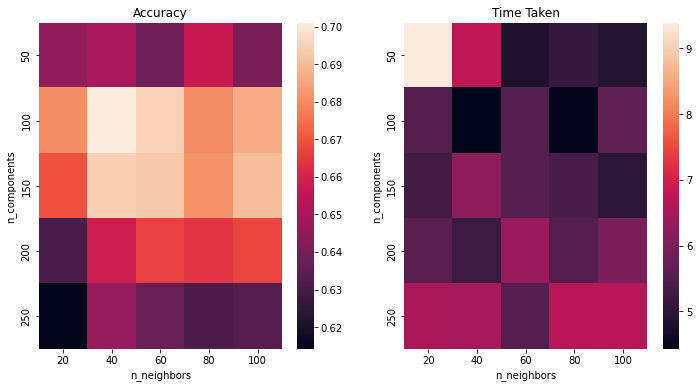

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(knn_df, ax=ax1)
ax1.set_xlabel("n_neighbors")
ax1.set_ylabel("n_components")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(times, index=component_k_values, columns=neighbors_k_values), ax=ax2)
ax2.set_xlabel("n_neighbors")
ax2.set_ylabel("n_components")
ax2.set_title("Time Taken")
plt.show()

TF-IDF once again outperforms Bag of Words, having accuracies that reach 70% -- still less than desirable, but much better than the 25% of Bag of Words. The optimal number of components is still 100, but with 40 neighbors instead of 60. From the heatmap, it would seem like this model also ran in one of the shortest amount of times, making it even more clearly the best choice.

In [ ]:
results[7][1] = knn_df.loc[100, 40]

## Neural Network with Bag of Words + Resampling + TruncatedSVD

We created a Neural Network with the Bag of Words model with different architectures to find the best structure. Below are the results (columns are the number of nodes per layer, rows are the dropout rates and the values in the cells are accuracy). When considering the accuracy together with the rest of the classification report, 1 layer with 750 nodes and 0.2 dropout performed the best.

1 layer: 

|  | 250 | 500 | 750 |
| --- | --- | --- | --- |
| 0 | 0.78 | 0.78 | 0.78 |
| 0.2 | 0.80 | 0.81 | 0.82 |
| 0.4 | 0.80 | 0.81 | 0.82 |
| 0.6 | 0.80 | 0.81 | 0.79 |
| 0.8 | 0.67 | 0.69 | 0.79 |

2 layers: 

|  | 250 | 500 | 750 |
| --- | --- | --- | --- |
| 0 | 0.78 | 0.79 | 0.80 |
| 0.2 | 0.81 | 0.81 | 0.81 |
| 0.4 | 0.82 | 0.81 | 0.81 |
| 0.6 | 0.76 | 0.81 | 0.77 |
| 0.8 | 0.49 | 0.49 | 0.48 |

3 layers:

|  | 250 | 500 | 750 |
| --- | --- | --- | --- |
| 0 | 0.78 | 0.81 | 0.79 |
| 0.2 | 0.66 | 0.81 | 0.79 |
| 0.4 | 0.66 | 0.81 | 0.81 |
| 0.6 | 0.73 | 0.72 | 0.70 |
| 0.8 | 0.11 | 0.72 | 0.24 |


In [ ]:
#Undersampling
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 5000)))
x, y = under.fit_resample(x_bag, data['type'])

#Dimensionality reduction
n_cols = 500
svd = TruncatedSVD(n_components=n_cols)
x = svd.fit_transform(x)

In [ ]:
#60:30:10 train:val:test
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.4)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.75)

#Oversampling
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)
x_val, y_val = smote.fit_resample(x_val, y_val)
x_test, y_test = smote.fit_resample(x_test, y_test)
y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)

In [ ]:
#Initialise model - 1 layer, 750 nodes, dropout of 0.2
model = Sequential()
model.add(Dropout(rate=0.2))
model.add(Dense(750, activation='relu'))
model.add(Dense(16, activation='softmax'))

#Compile model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

#Run model with early stopping
early_stopping_monitor = EarlyStopping(patience=3)
model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping_monitor])

y_pred = model.predict(x_test)

#For each of the testing data, find the type with highest probability
pred_types = []
types = y_train.columns
for i in range(len(y_pred)):
  pred_types.append(types[y_pred[i].argmax()])

Epoch 1/50
1515/1515 [==============================] - 13s 8ms/step - loss: 1.1961 - accuracy: 0.6576 - val_loss: 0.7662 - val_accuracy: 0.7843
Epoch 2/50
1515/1515 [==============================] - 11s 7ms/step - loss: 0.7348 - accuracy: 0.7878 - val_loss: 0.7081 - val_accuracy: 0.8004
Epoch 3/50
1515/1515 [==============================] - 11s 7ms/step - loss: 0.6609 - accuracy: 0.8073 - val_loss: 0.6761 - val_accuracy: 0.8093
Epoch 4/50
1515/1515 [==============================] - 11s 7ms/step - loss: 0.6146 - accuracy: 0.8168 - val_loss: 0.6726 - val_accuracy: 0.8083
Epoch 5/50
1515/1515 [==============================] - 10s 6ms/step - loss: 0.5802 - accuracy: 0.8260 - val_loss: 0.6727 - val_accuracy: 0.8103
Epoch 6/50
1515/1515 [==============================] - 9s 6ms/step - loss: 0.5514 - accuracy: 0.8332 - val_loss: 0.6748 - val_accuracy: 0.8052
Epoch 7/50
1515/1515 [==============================] - 10s 7ms/step - loss: 0.5338 - accuracy: 0.8390 - val_loss: 0.6793 - val_acc

In [ ]:
#Generate classification report
print(classification_report(y_test, pred_types))

              precision    recall  f1-score   support

        ENFJ       0.79      0.81      0.80      1559
        ENFP       0.65      0.86      0.74      1559
        ENTJ       0.89      0.79      0.84      1559
        ENTP       0.71      0.76      0.74      1559
        ESFJ       0.97      0.75      0.85      1559
        ESFP       0.94      0.86      0.89      1559
        ESTJ       0.95      0.89      0.92      1559
        ESTP       0.96      0.94      0.95      1559
        INFJ       0.70      0.77      0.73      1559
        INFP       0.72      0.70      0.71      1559
        INTJ       0.78      0.67      0.72      1559
        INTP       0.69      0.76      0.73      1559
        ISFJ       0.84      0.78      0.81      1559
        ISFP       0.80      0.82      0.81      1559
        ISTJ       0.83      0.85      0.84      1559
        ISTP       0.82      0.86      0.84      1559

    accuracy                           0.81     24944
   macro avg       0.81   

In [ ]:
results[8][0] = accuracy_score(y_test, pred_types)

## Neural Network with TF-IDF + Resampling + Truncated SVD

We also created a Neural Network with TF-IDF. Below are the results (columns are the number of nodes per layer, rows are the dropout rates and the values in the cells are accuracy). When considering the accuracy together with the rest of the classification report, 2 layers with 500 nodes and 0.2 dropout performed the best.

1 layer: 

|  | 250 | 500 | 750 |
| --- | --- | --- | --- |
| 0 | 0.76 | 0.77 | 0.78 |
| 0.2 | 0.79 | 0.79 | 0.79 |
| 0.4 | 0.79 | 0.80 | 0.80 |
| 0.6 | 0.80 | 0.80 | 0.79 |
| 0.8 | 0.79 | 0.79 | 0.80 |

2 layers: 

|  | 250 | 500 | 750 | 
| --- | --- | --- | --- |
| 0 | 0.81 | 0.81 | 0.82 |
| 0.2 | 0.81 | 0.83 | 0.82 |
| 0.4 | 0.82 | 0.82 | 0.82 |
| 0.6 | 0.80 | 0.81 | 0.81 |
| 0.8 | 0.54 | 0.51 | 0.47 | 

3 layers:

|  | 250 | 500 | 750 |
| --- | --- | --- | --- |
| 0 | 0.78 | 0.79 | 0.77 |
| 0.2 | 0.81 | 0.82 | 0.82 |
| 0.4 | 0.81 | 0.81 | 0.81 |
| 0.6 | 0.72 | 0.75 | 0.73 |
| 0.8 | 0.06 | 0.15 | 0.10 | 


In [ ]:
#Perform undersampling
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])

#Dimesionality reduction
svd = TruncatedSVD(n_components=250)
x = svd.fit_transform(x)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.4)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.75)

#Oversampling
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)
x_val, y_val = smote.fit_resample(x_val, y_val)
x_test, y_test = smote.fit_resample(x_test, y_test)
y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)
n_cols = x_train.shape[1]

In [ ]:
#Initialise - 1 layer with 500 nodes
model = Sequential()
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu', input_shape=(n_cols, )))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu', input_shape=(n_cols, )))
model.add(Dense(16, activation='softmax'))

#Compile model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

#Run model with early stopping
early_stopping_monitor = EarlyStopping(patience=2)
model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stopping_monitor])

y_pred = model.predict(x_test)

#For each of the testing data, find the type with highest probability
pred_types = []
types = y_train.columns
for i in range(len(y_pred)):
  pred_types.append(types[y_pred[i].argmax()])

Epoch 1/100
613/613 [==============================] - 4s 6ms/step - loss: 2.7660 - accuracy: 0.1096 - val_loss: 2.7568 - val_accuracy: 0.2166
Epoch 2/100
613/613 [==============================] - 4s 6ms/step - loss: 2.7534 - accuracy: 0.1837 - val_loss: 2.7423 - val_accuracy: 0.3355
Epoch 3/100
613/613 [==============================] - 4s 6ms/step - loss: 2.7389 - accuracy: 0.2435 - val_loss: 2.7247 - val_accuracy: 0.4263
Epoch 4/100
613/613 [==============================] - 4s 6ms/step - loss: 2.7193 - accuracy: 0.2894 - val_loss: 2.7017 - val_accuracy: 0.4101
Epoch 5/100
613/613 [==============================] - 4s 6ms/step - loss: 2.6947 - accuracy: 0.2981 - val_loss: 2.6713 - val_accuracy: 0.5262
Epoch 6/100
613/613 [==============================] - 4s 6ms/step - loss: 2.6613 - accuracy: 0.3355 - val_loss: 2.6315 - val_accuracy: 0.5153
Epoch 7/100
613/613 [==============================] - 4s 6ms/step - loss: 2.6191 - accuracy: 0.3457 - val_loss: 2.5827 - val_accuracy: 0.5173

In [ ]:
print(classification_report(y_test, pred_types))

              precision    recall  f1-score   support

        ENFJ       0.76      0.85      0.80       630
        ENFP       0.82      0.76      0.79       630
        ENTJ       0.87      0.88      0.87       630
        ENTP       0.81      0.73      0.77       630
        ESFJ       0.92      0.86      0.89       630
        ESFP       0.85      0.90      0.88       630
        ESTJ       0.94      0.94      0.94       630
        ESTP       0.95      0.94      0.95       630
        INFJ       0.80      0.73      0.76       630
        INFP       0.78      0.73      0.75       630
        INTJ       0.76      0.73      0.74       630
        INTP       0.65      0.82      0.73       630
        ISFJ       0.88      0.90      0.89       630
        ISFP       0.79      0.82      0.81       630
        ISTJ       0.87      0.83      0.85       630
        ISTP       0.87      0.84      0.86       630

    accuracy                           0.83     10080
   macro avg       0.83   

In [ ]:
results[8][1] = accuracy_score(y_test, pred_types)

## Conclusions



Placing all the scores we have obtained into a DataFrame:

In [ ]:
results = pd.DataFrame(results, columns=["bag", "tfidf"], index=["multi_naive_bayes", "comple_naive_bayes", "linearsvc", "svm", "linearsvc_truncatedsvd", "logreg", "random_forest", "knn", "neural_net"])
results

,bag,tfidf
multi_naive_bayes,0.677807,0.703125
comple_naive_bayes,0.761573,0.541859
linearsvc,0.798199,0.818572
svm,0.752091,0.804632
linearsvc_truncatedsvd,0.771606,0.810851
logreg,0.732361,0.802702
random_forest,0.506541,0.725928
knn,0.245121,0.701051
neural_net,0.799043,0.829266


We plot a barplot to see the general trends.

In [ ]:
flattened_results = pd.DataFrame(pd.concat([results.bag, results.tfidf]))
flattened_results["vectorization"] = ["bag_of_words"] * 9 + ["tf-idf"] * 9
flattened_results.columns = ["accuracy", "vectorization"]
flattened_results

,accuracy,vectorization
multi_naive_bayes,0.677807,bag_of_words
comple_naive_bayes,0.761573,bag_of_words
linearsvc,0.798199,bag_of_words
svm,0.752091,bag_of_words
linearsvc_truncatedsvd,0.771606,bag_of_words
logreg,0.732361,bag_of_words
random_forest,0.506541,bag_of_words
knn,0.245121,bag_of_words
neural_net,0.799043,bag_of_words
multi_naive_bayes,0.703125,tf-idf


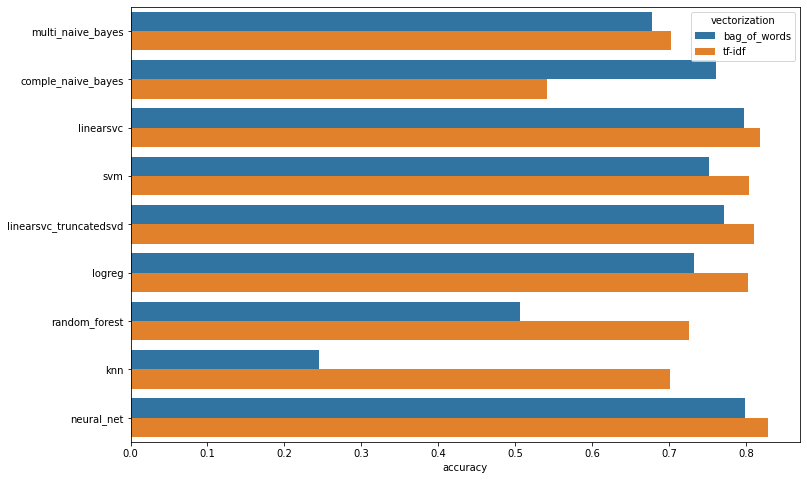

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x=flattened_results.accuracy, y=flattened_results.index, hue=flattened_results.vectorization)
plt.show()

We note the following observations.
- Our best performance was given by the Neural Network with tf-idf, followed by the LinearSVC models, without and with TruncatedSVD. 
- Using tf-idf to vectorize the input almost always gave a better result than the bag of words vectorization, with the notable exception of Complement Naive Bayes. Since tf-idf is generally more refined a vectorization than bag of words that captures more information about the importance of each word, this is expected. However, we cannot explain the drop in performance for Complement Naive Bayes.
- Complement Naive Bayes, when compared to the Multinomial Naive Bayes, showed an increase in performance when using Bag of Words but a decrease in performance instead when using tf-idf. The increase in performance from Bag of Words is likely due to to our imbalanced training data, which Complement Naive Bayes can handle better than Multinomial Naive Bayes. Since resampling was not performed for the Bag of Words model we used as our baseline, there is thus a high chance that our Complement Naive Bayes model performed better due to this.
- As expected, usage of TruncatedSVD reduces the accuracy slightly when comparing the LinearSVC models with and without it, due to information being lost when the reduction takes place. We note that tf-idf is impacted quite a bit less than the Bag of Words model. This could be because tf-idf also encoding the relative importance of words results in more information that is retained within the fewer parameters that remain after the TruncatedSVD is applied.
- We note that of all the models, KNN has a dramatic difference in performance between the Bag of Words model and the tf-idf model. This likely arises due to the sparsity and common values in the Bag of Words matrix, since the counts of words are likely to be 0, or otherwise low integers. Meanwhile, tf-idf is more likely to give a continuous range of values. Hence, it becomes easier to make the comparison for distance for tf-idf compared to Bag of Words.

# Function Prediction

Now, we attempt to predict the overall type of a person by first predicting the four functions associated with their personality type. However, due to how the four functions are assigned, we are able to define each combination of four functions using the ordered pair of their top two functions (i.e. the dominant and auxiliary functions), as well as their I/E type. We use the same models as with the direct prediction, with the exception of the Neural Network, since it would be too intensive to optimize individual parameters to predict each of the four functions. 

A possible merit of this method is that it is said that the MBTI functions are the most accurate representation of a person's behavior and thus the best indicator of their type. However, we concede that the encoding method we use may cause this information to be lost. However, we have determined it to be a poor idea to attempt to individually predict the ordered list of the four functions, as it would become very likely that the model would predict an illegal combination that would result in an invalid MBTI type.

For the data we track, we now attempt to compare the accuracies for the I/E type, the ordered pair, as well as the overall type that is synthesized from the former two.

In [ ]:
results = np.zeros(shape=(12, 3)).tolist()

In [ ]:
def toMbti(func):
  res = []
  for i in range(len(func[0])):
    mbti = func[0][i]
    if func[1][i] in ["NF", "NT", "SF", "ST"]:
      mbti += func[1][i]
      mbti += {"I": "J", "E": "P"}[mbti[0]]
    else:
      mbti += func[1][i][::-1]
      mbti += {"I": "P", "E": "J"}[mbti[0]]
    
    res.append(mbti)
  return res

## Naive Bayes with Bag of Words

In [ ]:
axes = ['I/E', 'dominant_auxiliary']
x = x_bag
y = data[axes]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

predicted_functions = []

for i in range(2):
  nb = MultinomialNB(alpha = 1)
  nb.fit(x_train, y_train.iloc[:,i].tolist())
  y_pred = nb.predict(x_test)
  print(axes[i])
  score = nb.score(x_test, y_test.iloc[:,i])
  print(score)
  results[0][i] = score
  print(classification_report(y_test.iloc[:,i], y_pred))
  predicted_functions.append(y_pred)

I/E
0.859479588950693
              precision    recall  f1-score   support

           E       0.82      0.54      0.65      5145
           I       0.87      0.96      0.91     16069

    accuracy                           0.86     21214
   macro avg       0.84      0.75      0.78     21214
weighted avg       0.86      0.86      0.85     21214

dominant_auxiliary
0.7338550014141605
              precision    recall  f1-score   support

          FN       0.70      0.53      0.60      2723
          FS       0.00      0.00      0.00       210
          NF       0.66      0.82      0.73      4200
          NT       0.72      0.85      0.78      6875
          SF       1.00      0.00      0.01       218
          ST       0.93      0.51      0.66       640
          TN       0.82      0.77      0.79      5587
          TS       0.88      0.23      0.36       761

    accuracy                           0.73     21214
   macro avg       0.71      0.46      0.49     21214
weighted avg     

In [ ]:
mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.T.values)

score = accuracy_score(mbti_test, mbti_pred)
print(score)
results[0][2] = score
print(classification_report(mbti_test, mbti_pred))

0.6426416517394173
              precision    recall  f1-score   support

        ENFJ       0.12      0.11      0.11       322
        ENFP       0.46      0.21      0.29      1228
        ENTJ       0.70      0.49      0.57       623
        ENTP       0.76      0.52      0.62      2361
        ESFJ       0.00      0.00      0.00        33
        ESFP       1.00      0.01      0.02        83
        ESTJ       0.66      0.80      0.72        98
        ESTP       0.93      0.83      0.87       397
        INFJ       0.51      0.81      0.63      2972
        INFP       0.74      0.54      0.62      2401
        INTJ       0.58      0.83      0.68      4514
        INTP       0.80      0.78      0.79      4964
        ISFJ       0.00      0.00      0.00       135
        ISFP       0.00      0.00      0.00       177
        ISTJ       0.00      0.00      0.00       243
        ISTP       0.92      0.11      0.19       663

    accuracy                           0.64     21214
   macr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Naive Bayes with TF-IDF

In [ ]:
axes = ['I/E', 'dominant_auxiliary']
x = x_tfidf
y = data[axes]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

predicted_functions = []

for i in range(2):
  nb = MultinomialNB(alpha = 1)
  nb.fit(x_train, y_train.iloc[:,i].tolist())
  y_pred = nb.predict(x_test)
  print(axes[i])
  score = nb.score(x_test, y_test.iloc[:,i])
  print(score)
  results[1][i] = score
  print(classification_report(y_test.iloc[:,i], y_pred))
  predicted_functions.append(y_pred)


I/E
0.76326953898369
              precision    recall  f1-score   support

           E       0.95      0.03      0.05      5145
           I       0.76      1.00      0.86     16069

    accuracy                           0.76     21214
   macro avg       0.86      0.51      0.46     21214
weighted avg       0.81      0.76      0.67     21214

dominant_auxiliary
0.3372772697275384


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          FN       0.50      0.00      0.00      2723
          FS       0.00      0.00      0.00       210
          NF       0.84      0.01      0.02      4200
          NT       0.33      1.00      0.49      6875
          SF       0.00      0.00      0.00       218
          ST       0.00      0.00      0.00       640
          TN       0.95      0.04      0.08      5587
          TS       1.00      0.03      0.05       761

    accuracy                           0.34     21214
   macro avg       0.45      0.13      0.08     21214
weighted avg       0.62      0.34      0.19     21214



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.T.values)

score = accuracy_score(mbti_test, mbti_pred)
print(score)
results[1][2] = score
print(classification_report(mbti_test, mbti_pred))

0.2219289148675403
              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       322
        ENFP       0.00      0.00      0.00      1228
        ENTJ       0.91      0.07      0.12       623
        ENTP       0.01      0.00      0.00      2361
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        83
        ESTJ       1.00      0.21      0.35        98
        ESTP       0.00      0.00      0.00       397
        INFJ       0.69      0.01      0.02      2972
        INFP       0.00      0.00      0.00      2401
        INTJ       0.22      1.00      0.36      4514
        INTP       0.53      0.02      0.04      4964
        ISFJ       0.00      0.00      0.00       135
        ISFP       0.00      0.00      0.00       177
        ISTJ       0.00      0.00      0.00       243
        ISTP       0.00      0.00      0.00       663

    accuracy                           0.22     21214
   macr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM with Bag of Words + Resampling + Truncated SVD

For the SVM, we test different values of C for the SVM and K for the TruncatedSVD dimensionality reduction. We individually optimize the C values for the I/E axis and the dominant and auxiliary functions, and then combine the best predictions of each to get a final accuracy score. 

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_bag, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

In [ ]:
ie_scores = [[0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0]]
ie_times = [[0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0]]
dominant_auxiliary_scores = [[0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0]]
dominant_auxiliary_times = [[0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0]]

In [ ]:
def predict(k):
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  y_train = toFunction(pd.DataFrame({'type':y_train}))
  y_test = toFunction(pd.DataFrame({'type':y_test}))

  predicted_functions = []
  
  for i in range(1,3):
    best_score = 0
    best_pred = []
    for j in range(5):
      c = [0.01, 0.1, 1, 10, 100][j]
      print(f'C: {c}')
      start_time = time.time()
      svc = SVC(C=c, class_weight='balanced')
      svc.fit(x_train, y_train.iloc[:,i].tolist())
      y_pred = svc.predict(x_test)
      print(axes[i-1])
      score = svc.score(x_test, y_test.iloc[:,i])
      if score > best_score:
        best_score = score
        best_pred = y_pred
      print(score)
      [ie_scores, dominant_auxiliary_scores][i - 1][k // 50 - 1][j] = score
      [ie_times, dominant_auxiliary_times][i - 1][k // 50 - 1][j] = time.time() - start_time
      print(classification_report(y_test.iloc[:,i], y_pred))
    predicted_functions.append(best_pred)

  mbti_pred = toMbti(predicted_functions)
  mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

  print(accuracy_score(mbti_test, mbti_pred))
  print(classification_report(mbti_test, mbti_pred))

In [ ]:
print('k: 50')
predict(50)

k: 50
C: 0.01
I/E
0.6521552648509543
              precision    recall  f1-score   support

           E       0.64      0.55      0.59      2154
           I       0.66      0.74      0.70      2509

    accuracy                           0.65      4663
   macro avg       0.65      0.64      0.64      4663
weighted avg       0.65      0.65      0.65      4663

C: 0.1
I/E
0.690542569161484
              precision    recall  f1-score   support

           E       0.67      0.65      0.66      2154
           I       0.71      0.72      0.72      2509

    accuracy                           0.69      4663
   macro avg       0.69      0.69      0.69      4663
weighted avg       0.69      0.69      0.69      4663

C: 1
I/E
0.7158481664164701
              precision    recall  f1-score   support

           E       0.70      0.68      0.69      2154
           I       0.73      0.74      0.74      2509

    accuracy                           0.72      4663
   macro avg       0.71      0.71 

In [ ]:
print('k: 100')
predict(100)

k: 100
C: 0.01
I/E
0.716491529058546
              precision    recall  f1-score   support

           E       0.76      0.56      0.65      2154
           I       0.69      0.85      0.76      2509

    accuracy                           0.72      4663
   macro avg       0.73      0.71      0.71      4663
weighted avg       0.72      0.72      0.71      4663

C: 0.1
I/E
0.8048466652369719
              precision    recall  f1-score   support

           E       0.81      0.75      0.78      2154
           I       0.80      0.85      0.82      2509

    accuracy                           0.80      4663
   macro avg       0.81      0.80      0.80      4663
weighted avg       0.81      0.80      0.80      4663

C: 1
I/E
0.825219815569376
              precision    recall  f1-score   support

           E       0.82      0.80      0.81      2154
           I       0.83      0.85      0.84      2509

    accuracy                           0.83      4663
   macro avg       0.82      0.82 

In [ ]:
print('k: 150')
predict(150)

k: 150
C: 0.01
I/E
0.7179927085567231
              precision    recall  f1-score   support

           E       0.77      0.56      0.65      2154
           I       0.69      0.86      0.77      2509

    accuracy                           0.72      4663
   macro avg       0.73      0.71      0.71      4663
weighted avg       0.73      0.72      0.71      4663

C: 0.1
I/E
0.8194295517906927
              precision    recall  f1-score   support

           E       0.83      0.77      0.80      2154
           I       0.81      0.87      0.84      2509

    accuracy                           0.82      4663
   macro avg       0.82      0.82      0.82      4663
weighted avg       0.82      0.82      0.82      4663

C: 1
I/E
0.839373793695046
              precision    recall  f1-score   support

           E       0.83      0.82      0.82      2154
           I       0.84      0.86      0.85      2509

    accuracy                           0.84      4663
   macro avg       0.84      0.84

In [ ]:
print('k: 200')
predict(200)

k: 200
C: 0.01
I/E
0.7143469869182929
              precision    recall  f1-score   support

           E       0.77      0.55      0.64      2154
           I       0.69      0.86      0.76      2509

    accuracy                           0.71      4663
   macro avg       0.73      0.70      0.70      4663
weighted avg       0.73      0.71      0.71      4663

C: 0.1
I/E
0.8245764529273
              precision    recall  f1-score   support

           E       0.84      0.76      0.80      2154
           I       0.81      0.88      0.84      2509

    accuracy                           0.82      4663
   macro avg       0.83      0.82      0.82      4663
weighted avg       0.83      0.82      0.82      4663

C: 1
I/E
0.848380870684109
              precision    recall  f1-score   support

           E       0.85      0.82      0.83      2154
           I       0.85      0.87      0.86      2509

    accuracy                           0.85      4663
   macro avg       0.85      0.85   

In [ ]:
print('k: 250')
predict(250)

k: 250
C: 0.01
I/E
0.7102723568518121
              precision    recall  f1-score   support

           E       0.77      0.53      0.63      2154
           I       0.68      0.86      0.76      2509

    accuracy                           0.71      4663
   macro avg       0.73      0.70      0.70      4663
weighted avg       0.72      0.71      0.70      4663

C: 0.1
I/E
0.8258631782114518
              precision    recall  f1-score   support

           E       0.84      0.76      0.80      2154
           I       0.81      0.88      0.84      2509

    accuracy                           0.83      4663
   macro avg       0.83      0.82      0.82      4663
weighted avg       0.83      0.83      0.82      4663

C: 1
I/E
0.8496675959682608
              precision    recall  f1-score   support

           E       0.85      0.82      0.83      2154
           I       0.85      0.87      0.86      2509

    accuracy                           0.85      4663
   macro avg       0.85      0.8

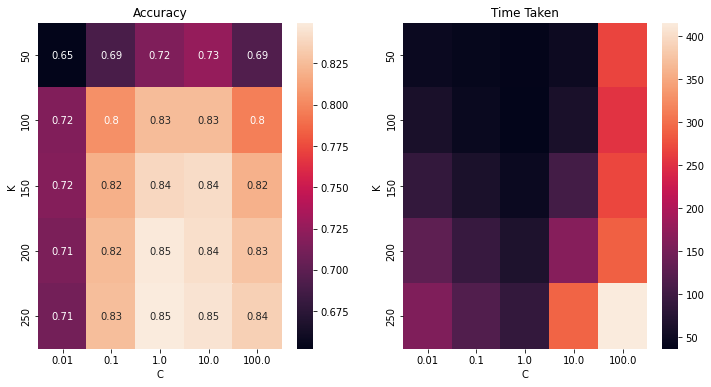

In [ ]:
ie_scores_df = pd.DataFrame(ie_scores, index=range(50, 251, 50), columns=[0.01, 0.1, 1, 10, 100])
ie_times_df = pd.DataFrame(ie_times, index=range(50, 251, 50), columns=[0.01, 0.1, 1, 10, 100])
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(ie_scores_df, annot=True, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("K")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(ie_times_df, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("K")
ax2.set_title("Time Taken")

plt.show()

For the I/E predictions, we see that the best value is K = 250 and C = 1.0, which also runs in a relatively quick time compared to the others. 

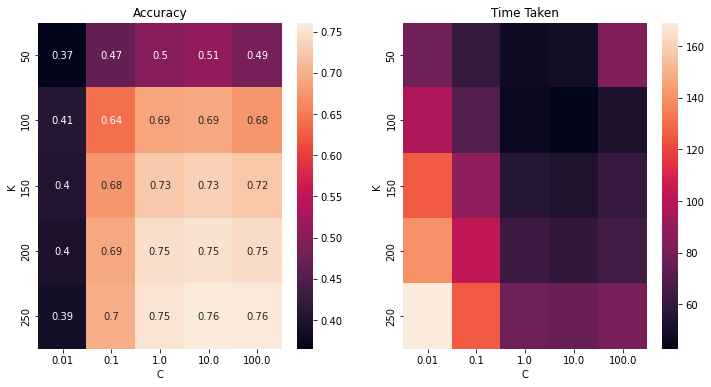

In [ ]:
domaux_scores_df = pd.DataFrame(dominant_auxiliary_scores, index=range(50, 251, 50), columns=[0.01, 0.1, 1, 10, 100])
domaux_times_df = pd.DataFrame(dominant_auxiliary_times, index=range(50, 251, 50), columns=[0.01, 0.1, 1, 10, 100])
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(domaux_scores_df, annot=True, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("K")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(domaux_times_df, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("K")
ax2.set_title("Time Taken")

plt.show()

We note the interesting reversal in trend: The time taken seems to increase for smaller values of C for the dominant/auxiliary functions, while the converse is true for the I/E axis. The best value this time occurs at C = 10.0, K = 250.



In [ ]:
results[2][0] = ie_scores_df.loc[250, 1.0]
results[2][1] = ie_scores_df.loc[250, 10.0]


In [ ]:
best_functions = []
svd = TruncatedSVD(n_components=250)
x_t = svd.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

# for the I/E axis
svc = SVC(C=1, class_weight='balanced')
svc.fit(x_train, y_train.iloc[:,1].tolist())
y_pred = svc.predict(x_test)
best_functions.append(y_pred)

# For the functions
svc = SVC(C=10, class_weight='balanced')
svc.fit(x_train, y_train.iloc[:,2].tolist())
y_pred = svc.predict(x_test)
best_functions.append(y_pred)

mbti_pred = toMbti(best_functions)
mbti_test = toMbti(y_test.T.values[1:])

score = accuracy_score(mbti_test, mbti_pred)
print(score)
results[2][2] = score
print(classification_report(mbti_test, mbti_pred))

0.6725284151833584
              precision    recall  f1-score   support

        ENFJ       0.69      0.63      0.66       311
        ENFP       0.68      0.67      0.67       403
        ENTJ       0.77      0.70      0.74       395
        ENTP       0.68      0.64      0.66       430
        ESFJ       0.23      0.29      0.26        42
        ESFP       0.42      0.38      0.40        71
        ESTJ       0.61      0.70      0.65       106
        ESTP       0.85      0.88      0.86       396
        INFJ       0.60      0.64      0.62       411
        INFP       0.60      0.70      0.65       378
        INTJ       0.55      0.66      0.60       367
        INTP       0.66      0.64      0.65       407
        ISFJ       0.61      0.53      0.57       120
        ISFP       0.73      0.63      0.68       167
        ISTJ       0.70      0.72      0.71       247
        ISTP       0.81      0.67      0.74       412

    accuracy                           0.67      4663
   macr

## SVM with TF-IDF + Resampling + Truncated SVD

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

In [ ]:
ie_scores = [[0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0]]
ie_times = [[0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0]]
dominant_auxiliary_scores = [[0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0]]
dominant_auxiliary_times = [[0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0], [0 ,0, 0, 0, 0]]

In [ ]:
def predict(k):
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  y_train = toFunction(pd.DataFrame({'type':y_train}))
  y_test = toFunction(pd.DataFrame({'type':y_test}))

  predicted_functions = []
  
  for i in range(1,3):
    best_score = 0
    best_pred = []
    for j in range(5):
      c = [0.01, 0.1, 1, 10, 100][j]
      print(f'C: {c}')
      start_time = time.time()
      svc = SVC(C=c, class_weight='balanced')
      svc.fit(x_train, y_train.iloc[:,i].tolist())
      y_pred = svc.predict(x_test)
      print(axes[i-1])
      score = svc.score(x_test, y_test.iloc[:,i])
      if score > best_score:
        best_score = score
        best_pred = y_pred
      print(score)
      [ie_scores, dominant_auxiliary_scores][i - 1][k // 50 - 1][j] = score
      [ie_times, dominant_auxiliary_times][i - 1][k // 50 - 1][j] = time.time() - start_time
      print(classification_report(y_test.iloc[:,i], y_pred))
    predicted_functions.append(best_pred)

  mbti_pred = toMbti(predicted_functions)
  mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

  print(accuracy_score(mbti_test, mbti_pred))
  print(classification_report(mbti_test, mbti_pred))

In [ ]:
print('k: 50')
predict(50)

k: 50
C: 0.01
I/E
0.8312245335620845
              precision    recall  f1-score   support

           E       0.88      0.73      0.80      2154
           I       0.80      0.92      0.85      2509

    accuracy                           0.83      4663
   macro avg       0.84      0.82      0.83      4663
weighted avg       0.84      0.83      0.83      4663

C: 0.1
I/E
0.8674672957323611
              precision    recall  f1-score   support

           E       0.88      0.82      0.85      2154
           I       0.86      0.91      0.88      2509

    accuracy                           0.87      4663
   macro avg       0.87      0.86      0.87      4663
weighted avg       0.87      0.87      0.87      4663

C: 1
I/E
0.8811923654299807
              precision    recall  f1-score   support

           E       0.89      0.85      0.87      2154
           I       0.87      0.91      0.89      2509

    accuracy                           0.88      4663
   macro avg       0.88      0.88

In [ ]:
print('k: 100')
predict(100)

k: 100
C: 0.01
I/E
0.8159982843662879
              precision    recall  f1-score   support

           E       0.88      0.69      0.78      2154
           I       0.78      0.92      0.84      2509

    accuracy                           0.82      4663
   macro avg       0.83      0.81      0.81      4663
weighted avg       0.83      0.82      0.81      4663

C: 0.1
I/E
0.868754021016513
              precision    recall  f1-score   support

           E       0.88      0.82      0.85      2154
           I       0.86      0.91      0.88      2509

    accuracy                           0.87      4663
   macro avg       0.87      0.87      0.87      4663
weighted avg       0.87      0.87      0.87      4663

C: 1
I/E
0.8799056401458288
              precision    recall  f1-score   support

           E       0.89      0.85      0.87      2154
           I       0.87      0.91      0.89      2509

    accuracy                           0.88      4663
   macro avg       0.88      0.88

In [ ]:
print('k: 150')
predict(150)

k: 150
C: 0.01
I/E
0.8067767531631996
              precision    recall  f1-score   support

           E       0.89      0.67      0.76      2154
           I       0.76      0.93      0.84      2509

    accuracy                           0.81      4663
   macro avg       0.83      0.80      0.80      4663
weighted avg       0.82      0.81      0.80      4663

C: 0.1
I/E
0.8689684752305383
              precision    recall  f1-score   support

           E       0.89      0.82      0.85      2154
           I       0.85      0.91      0.88      2509

    accuracy                           0.87      4663
   macro avg       0.87      0.87      0.87      4663
weighted avg       0.87      0.87      0.87      4663

C: 1
I/E
0.8784044606476518
              precision    recall  f1-score   support

           E       0.89      0.85      0.87      2154
           I       0.87      0.91      0.89      2509

    accuracy                           0.88      4663
   macro avg       0.88      0.8

In [ ]:
print('k: 200')
predict(200)

k: 200
C: 0.01
I/E
0.7906926871113017
              precision    recall  f1-score   support

           E       0.89      0.62      0.73      2154
           I       0.74      0.93      0.83      2509

    accuracy                           0.79      4663
   macro avg       0.82      0.78      0.78      4663
weighted avg       0.81      0.79      0.78      4663

C: 0.1
I/E
0.8683251125884623
              precision    recall  f1-score   support

           E       0.89      0.82      0.85      2154
           I       0.85      0.91      0.88      2509

    accuracy                           0.87      4663
   macro avg       0.87      0.86      0.87      4663
weighted avg       0.87      0.87      0.87      4663

C: 1
I/E
0.8771177353634999
              precision    recall  f1-score   support

           E       0.88      0.85      0.86      2154
           I       0.87      0.90      0.89      2509

    accuracy                           0.88      4663
   macro avg       0.88      0.8

In [ ]:
print('k: 250')
predict(250)

k: 250
C: 0.01
I/E
0.7750375294874544
              precision    recall  f1-score   support

           E       0.90      0.58      0.70      2154
           I       0.72      0.94      0.82      2509

    accuracy                           0.78      4663
   macro avg       0.81      0.76      0.76      4663
weighted avg       0.80      0.78      0.77      4663

C: 0.1
I/E
0.8698262920866395
              precision    recall  f1-score   support

           E       0.90      0.81      0.85      2154
           I       0.85      0.92      0.88      2509

    accuracy                           0.87      4663
   macro avg       0.87      0.87      0.87      4663
weighted avg       0.87      0.87      0.87      4663

C: 1
I/E
0.8799056401458288
              precision    recall  f1-score   support

           E       0.89      0.85      0.87      2154
           I       0.87      0.91      0.89      2509

    accuracy                           0.88      4663
   macro avg       0.88      0.8

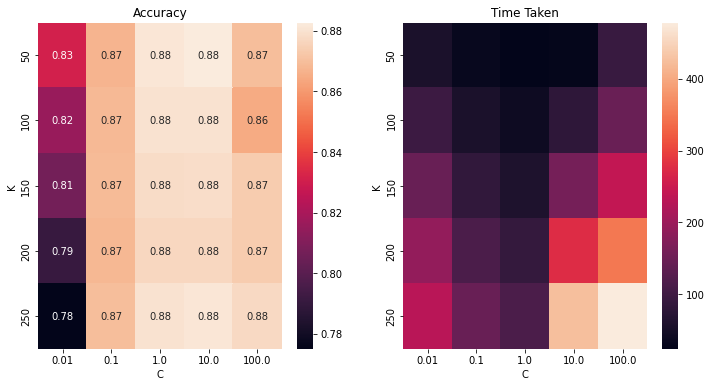

In [ ]:
ie_scores_df = pd.DataFrame(ie_scores, index=range(50, 251, 50), columns=[0.01, 0.1, 1, 10, 100])
ie_times_df = pd.DataFrame(ie_times, index=range(50, 251, 50), columns=[0.01, 0.1, 1, 10, 100])
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(ie_scores_df, annot=True, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("K")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(ie_times_df, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("K")
ax2.set_title("Time Taken")

plt.show()

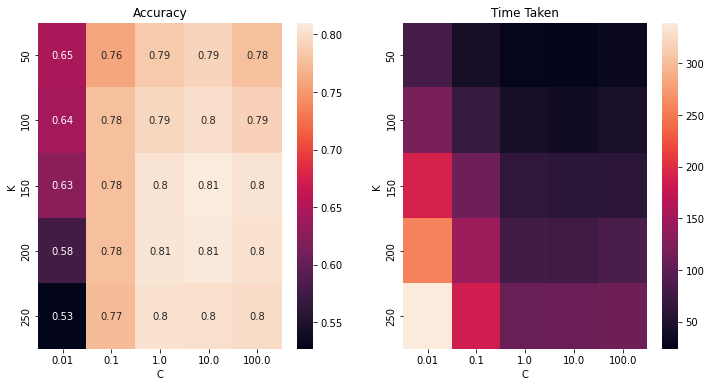

In [ ]:
domaux_scores_df = pd.DataFrame(dominant_auxiliary_scores, index=range(50, 251, 50), columns=[0.01, 0.1, 1, 10, 100])
domaux_times_df = pd.DataFrame(dominant_auxiliary_times, index=range(50, 251, 50), columns=[0.01, 0.1, 1, 10, 100])
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(domaux_scores_df, annot=True, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("K")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(domaux_times_df, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("K")
ax2.set_title("Time Taken")

plt.show()

The I/E prediction performs best with C = 10 and K = 50, while the function prediction has the optial value of C = 10 and K = 150 (while the performance for K = 250 is slightly higher, this difference is marginal and thus we pursue the lower computation time).

In [ ]:
results[3][0] = ie_scores_df.loc[50, 10.0]
results[3][1] = domaux_scores_df.loc[150, 10]


In [ ]:
best_functions = []
svd = TruncatedSVD(n_components=50)
x_t = svd.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

# for the I/E axis
svc = SVC(C=10, class_weight='balanced')
svc.fit(x_train, y_train.iloc[:,1].tolist())
y_pred = svc.predict(x_test)
best_functions.append(y_pred)
y_test1 = y_test

# For the functions
svd = TruncatedSVD(n_components=150)
x_t = svd.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

svc = SVC(C=10, class_weight='balanced')
svc.fit(x_train, y_train.iloc[:,2].tolist())
y_pred = svc.predict(x_test)
best_functions.append(y_pred)

mbti_pred = toMbti(best_functions)
mbti_test = toMbti(y_test.T.values[1:])

score = accuracy_score(mbti_test, mbti_pred)
print(score)
results[3][2] = score
print(classification_report(mbti_test, mbti_pred))

0.7505897490885696
              precision    recall  f1-score   support

        ENFJ       0.75      0.68      0.72       311
        ENFP       0.75      0.76      0.75       403
        ENTJ       0.83      0.80      0.81       395
        ENTP       0.75      0.70      0.73       430
        ESFJ       0.44      0.52      0.48        42
        ESFP       0.59      0.51      0.55        71
        ESTJ       0.73      0.81      0.77       106
        ESTP       0.94      0.88      0.91       396
        INFJ       0.70      0.76      0.73       411
        INFP       0.66      0.71      0.69       378
        INTJ       0.60      0.69      0.64       367
        INTP       0.75      0.74      0.74       407
        ISFJ       0.66      0.71      0.69       120
        ISFP       0.74      0.69      0.72       167
        ISTJ       0.77      0.77      0.77       247
        ISTP       0.91      0.84      0.87       412

    accuracy                           0.75      4663
   macr

## LinearSVC with Bag of Words + Resampling

From Part 1, we find that dimensionality reduction is likely unnecessary for LinearSVC, and hence opt to exclude it here.

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_bag, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

In [ ]:
ie_scores = []
ie_times = []
domaux_scores = []
domaux_times = []
predicted_functions = []
c_values = [0.01, 0.1, 1, 10, 100]

for i in range(1,3):
  best_score = 0
  best_pred = []
  for j in range(5):
    c = c_values[j]
    print(f'C: {c}')
    start_time = time.time()
    svc = LinearSVC(C=c, class_weight='balanced', dual=False)
    svc.fit(x_train, y_train.iloc[:,i].tolist())
    y_pred = svc.predict(x_test)
    print(axes[i-1])
    score = svc.score(x_test, y_test.iloc[:,i])
    [ie_scores, domaux_scores][i-1].append(score)
    [ie_times, domaux_times][i-1].append(time.time() - start_time)
    if score > best_score:
      best_score = score
      best_pred = y_pred
    print(score)
    print(classification_report(y_test.iloc[:,i], y_pred))
  predicted_functions.append(best_pred)


C: 0.01
I/E
0.8458074201158052
              precision    recall  f1-score   support

           E       0.84      0.83      0.83      2154
           I       0.85      0.86      0.86      2509

    accuracy                           0.85      4663
   macro avg       0.85      0.84      0.84      4663
weighted avg       0.85      0.85      0.85      4663

C: 0.1
I/E
0.8292944456358567
              precision    recall  f1-score   support

           E       0.82      0.81      0.81      2154
           I       0.84      0.85      0.84      2509

    accuracy                           0.83      4663
   macro avg       0.83      0.83      0.83      4663
weighted avg       0.83      0.83      0.83      4663

C: 1
I/E
0.827364357709629
              precision    recall  f1-score   support

           E       0.82      0.80      0.81      2154
           I       0.83      0.85      0.84      2509

    accuracy                           0.83      4663
   macro avg       0.83      0.83      0

In [ ]:
ie_scores

[0.8458074201158052,
 0.8292944456358567,
 0.827364357709629,
 0.8213596397169204,
 0.8256487239974265]

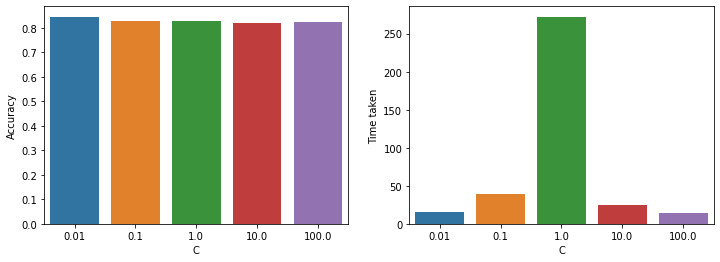

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=c_values, y=ie_scores, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=c_values, y=ie_times, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("Time taken")
plt.show()

There is an interesting spike in the time taken at C = 1.0, being nearly six times the next highest time. The accuracies, meanwhile, are all very even, with C = 0.01 being the highest. 

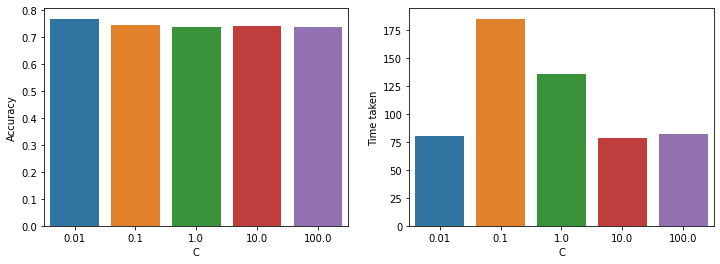

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=c_values, y=domaux_scores, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=c_values, y=domaux_times, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("Time taken")
plt.show()

For the functions, the spike is instead at C = 0.1. The accuracies remain similar, with 0.01 having the highest accuracy once again.

In [ ]:
mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

print(accuracy_score(mbti_test, mbti_pred))
print(classification_report(mbti_test, mbti_pred))

0.6729573236114089
              precision    recall  f1-score   support

        ENFJ       0.71      0.67      0.69       311
        ENFP       0.66      0.69      0.67       403
        ENTJ       0.74      0.75      0.74       395
        ENTP       0.67      0.61      0.64       430
        ESFJ       0.41      0.50      0.45        42
        ESFP       0.57      0.55      0.56        71
        ESTJ       0.66      0.81      0.73       106
        ESTP       0.90      0.84      0.87       396
        INFJ       0.59      0.61      0.60       411
        INFP       0.60      0.63      0.62       378
        INTJ       0.51      0.60      0.55       367
        INTP       0.62      0.58      0.60       407
        ISFJ       0.62      0.65      0.64       120
        ISFP       0.71      0.60      0.65       167
        ISTJ       0.71      0.75      0.73       247
        ISTP       0.81      0.75      0.78       412

    accuracy                           0.67      4663
   macr

In [ ]:
results[4][0] = ie_scores[0]
results[4][1] = domaux_scores[1]
results[4][2] = accuracy_score(mbti_test, mbti_pred)

## LinearSVC with TF-IDF + Resampling

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

In [ ]:
ie_scores = []
ie_times = []
domaux_scores = []
domaux_times = []
predicted_functions = []
c_values = [0.01, 0.1, 1, 10, 100]

for i in range(1,3):
  best_score = 0
  best_pred = []
  for j in range(5):
    c = c_values[j]
    print(f'C: {c}')
    start_time = time.time()
    svc = LinearSVC(C=c, class_weight='balanced', dual=False)
    svc.fit(x_train, y_train.iloc[:,i].tolist())
    y_pred = svc.predict(x_test)
    print(axes[i-1])
    score = svc.score(x_test, y_test.iloc[:,i])
    [ie_scores, domaux_scores][i-1].append(score)
    [ie_times, domaux_times][i-1].append(time.time() - start_time)
    if score > best_score:
      best_score = score
      best_pred = y_pred
    print(score)
    print(classification_report(y_test.iloc[:,i], y_pred))
  predicted_functions.append(best_pred)


C: 0.01
I/E
0.8290799914218314
              precision    recall  f1-score   support

           E       0.84      0.77      0.81      2154
           I       0.82      0.88      0.85      2509

    accuracy                           0.83      4663
   macro avg       0.83      0.83      0.83      4663
weighted avg       0.83      0.83      0.83      4663

C: 0.1
I/E
0.8685395668024877
              precision    recall  f1-score   support

           E       0.87      0.84      0.85      2154
           I       0.86      0.90      0.88      2509

    accuracy                           0.87      4663
   macro avg       0.87      0.87      0.87      4663
weighted avg       0.87      0.87      0.87      4663

C: 1
I/E
0.8595324898134248
              precision    recall  f1-score   support

           E       0.86      0.83      0.85      2154
           I       0.86      0.88      0.87      2509

    accuracy                           0.86      4663
   macro avg       0.86      0.86      

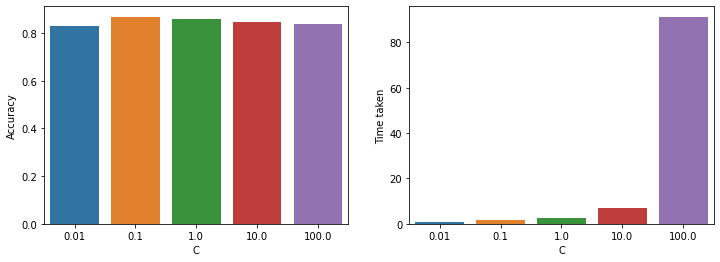

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=c_values, y=ie_scores, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=c_values, y=ie_times, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("Time taken")
plt.show()

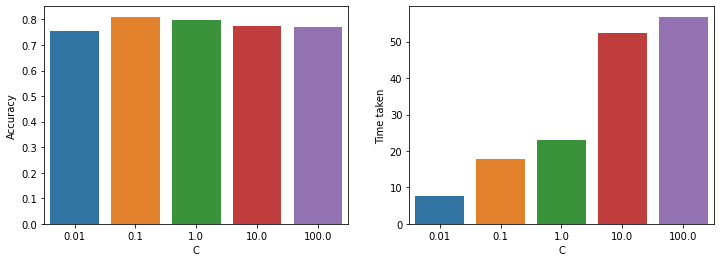

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=c_values, y=domaux_scores, ax=ax1)
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=c_values, y=domaux_times, ax=ax2)
ax2.set_xlabel("C")
ax2.set_ylabel("Time taken")
plt.show()

C = 0.1 gives the best result for both.

In [ ]:
mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

score = accuracy_score(mbti_test, mbti_pred)
print(score)
print(classification_report(mbti_test, mbti_pred))

0.7310744156122668
              precision    recall  f1-score   support

        ENFJ       0.82      0.72      0.76       311
        ENFP       0.75      0.69      0.72       403
        ENTJ       0.82      0.83      0.82       395
        ENTP       0.82      0.67      0.74       430
        ESFJ       0.33      0.50      0.40        42
        ESFP       0.52      0.56      0.54        71
        ESTJ       0.69      0.75      0.71       106
        ESTP       0.90      0.93      0.92       396
        INFJ       0.63      0.70      0.66       411
        INFP       0.70      0.68      0.69       378
        INTJ       0.56      0.66      0.61       367
        INTP       0.69      0.64      0.66       407
        ISFJ       0.58      0.76      0.66       120
        ISFP       0.70      0.73      0.71       167
        ISTJ       0.72      0.75      0.74       247
        ISTP       0.88      0.82      0.85       412

    accuracy                           0.73      4663
   macr

In [ ]:
results[5][0] = ie_scores[1]
results[5][1] = domaux_scores[i]
results[5][2] = score

## Logistic Regression with Bag of Words

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
x = x_bag
y = data[axes]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

predicted_functions = []

for i in range(2):
  lr = LogisticRegression(max_iter = 200)
  lr.fit(x_train, y_train.iloc[:,i].tolist())
  y_pred = lr.predict(x_test)
  print(axes[i])
  score = lr.score(x_test, y_test.iloc[:,i])
  print(score)
  results[6][i] = score
  print(classification_report(y_test.iloc[:,i], y_pred))
  predicted_functions.append(y_pred)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


I/E
0.8901197322522862
              precision    recall  f1-score   support

           E       0.79      0.75      0.77      5145
           I       0.92      0.94      0.93     16069

    accuracy                           0.89     21214
   macro avg       0.85      0.84      0.85     21214
weighted avg       0.89      0.89      0.89     21214



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


dominant_auxiliary
0.8115395493542
              precision    recall  f1-score   support

          FN       0.78      0.76      0.77      2723
          FS       0.66      0.51      0.58       210
          NF       0.81      0.81      0.81      4200
          NT       0.81      0.84      0.83      6875
          SF       0.68      0.58      0.63       218
          ST       0.87      0.73      0.79       640
          TN       0.82      0.83      0.83      5587
          TS       0.83      0.75      0.79       761

    accuracy                           0.81     21214
   macro avg       0.78      0.73      0.75     21214
weighted avg       0.81      0.81      0.81     21214



In [ ]:
mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.T.values)

score = accuracy_score(mbti_test, mbti_pred)
print(score)
results[6][2] = score
print(classification_report(mbti_test, mbti_pred))

0.7382388988403884
              precision    recall  f1-score   support

        ENFJ       0.38      0.42      0.40       322
        ENFP       0.65      0.58      0.61      1228
        ENTJ       0.55      0.64      0.59       623
        ENTP       0.75      0.69      0.72      2361
        ESFJ       0.23      0.30      0.26        33
        ESFP       0.49      0.28      0.35        83
        ESTJ       0.48      0.76      0.58        98
        ESTP       0.91      0.75      0.82       397
        INFJ       0.74      0.77      0.75      2972
        INFP       0.77      0.73      0.75      2401
        INTJ       0.72      0.80      0.76      4514
        INTP       0.82      0.81      0.81      4964
        ISFJ       0.54      0.56      0.55       135
        ISFP       0.69      0.47      0.56       177
        ISTJ       0.58      0.51      0.54       243
        ISTP       0.84      0.67      0.75       663

    accuracy                           0.74     21214
   macr

## Logistic Regression with TF-IDF

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
x = x_tfidf
y = data[axes]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

predicted_functions = []

for i in range(2):
  lr = LogisticRegression(max_iter = 200)
  lr.fit(x_train, y_train.iloc[:,i].tolist())
  y_pred = lr.predict(x_test)
  print(axes[i])
  score = lr.score(x_test, y_test.iloc[:,i])
  print(score)
  results[7][i] = score
  print(classification_report(y_test.iloc[:,i], y_pred))
  predicted_functions.append(y_pred)



I/E
0.9037899500329971
              precision    recall  f1-score   support

           E       0.88      0.70      0.78      5145
           I       0.91      0.97      0.94     16069

    accuracy                           0.90     21214
   macro avg       0.89      0.83      0.86     21214
weighted avg       0.90      0.90      0.90     21214



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


dominant_auxiliary
0.8307249929291977
              precision    recall  f1-score   support

          FN       0.83      0.77      0.80      2723
          FS       0.81      0.42      0.56       210
          NF       0.83      0.83      0.83      4200
          NT       0.82      0.88      0.85      6875
          SF       0.86      0.40      0.55       218
          ST       0.94      0.67      0.79       640
          TN       0.84      0.87      0.85      5587
          TS       0.89      0.69      0.77       761

    accuracy                           0.83     21214
   macro avg       0.85      0.69      0.75     21214
weighted avg       0.83      0.83      0.83     21214



In [ ]:
mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.T.values)

score = accuracy_score(mbti_test, mbti_pred)
print(score)
results[7][2] = score
print(classification_report(mbti_test, mbti_pred))

0.768690487413972
              precision    recall  f1-score   support

        ENFJ       0.52      0.35      0.42       322
        ENFP       0.74      0.56      0.63      1228
        ENTJ       0.72      0.61      0.66       623
        ENTP       0.82      0.68      0.74      2361
        ESFJ       0.35      0.18      0.24        33
        ESFP       0.62      0.16      0.25        83
        ESTJ       0.67      0.72      0.70        98
        ESTP       0.96      0.75      0.84       397
        INFJ       0.73      0.81      0.77      2972
        INFP       0.81      0.78      0.79      2401
        INTJ       0.71      0.86      0.78      4514
        INTP       0.82      0.87      0.85      4964
        ISFJ       0.69      0.41      0.51       135
        ISFP       0.82      0.43      0.56       177
        ISTJ       0.67      0.42      0.51       243
        ISTP       0.88      0.64      0.74       663

    accuracy                           0.77     21214
   macro

## Random Forest with Bag of Words + Resampling + Truncated SVD

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_bag, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))
ie_scores = []
ie_times = []
domaux_scores = []
domaux_times = []

In [ ]:
def predict(k):
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  y_train = toFunction(pd.DataFrame({'type':y_train}))
  y_test = toFunction(pd.DataFrame({'type':y_test}))

  predicted_functions = []
  
  for i in range(1,3):
    start_time = time.time()
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(x_train, y_train.iloc[:,i].tolist())
    y_pred = rf.predict(x_test)
    print(axes[i-1])
    score = rf.score(x_test, y_test.iloc[:,i])
    [ie_scores, domaux_scores][i-1].append(score)
    [ie_times, domaux_times][i-1].append(time.time() - start_time)
    print(score)
    print(classification_report(y_test.iloc[:,i], y_pred))
    predicted_functions.append(y_pred)

  mbti_pred = toMbti(predicted_functions)
  mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

  print(accuracy_score(mbti_test, mbti_pred))
  print(classification_report(mbti_test, mbti_pred))


In [ ]:
for k in range(50, 251, 50):
  print(f'k: {k}')
  predict(k)

k: 50
I/E
0.6830366716705983
              precision    recall  f1-score   support

           E       0.71      0.53      0.61      2154
           I       0.67      0.82      0.73      2509

    accuracy                           0.68      4663
   macro avg       0.69      0.67      0.67      4663
weighted avg       0.69      0.68      0.68      4663

dominant_auxiliary
0.40767746086210593
              precision    recall  f1-score   support

          FN       0.34      0.41      0.37       689
          FS       0.43      0.17      0.24       209
          NF       0.42      0.57      0.49       814
          NT       0.31      0.38      0.34       797
          SF       0.33      0.05      0.08       191
          ST       0.64      0.53      0.58       643
          TN       0.38      0.47      0.42       802
          TS       0.61      0.18      0.28       518

    accuracy                           0.41      4663
   macro avg       0.43      0.34      0.35      4663
weighted 

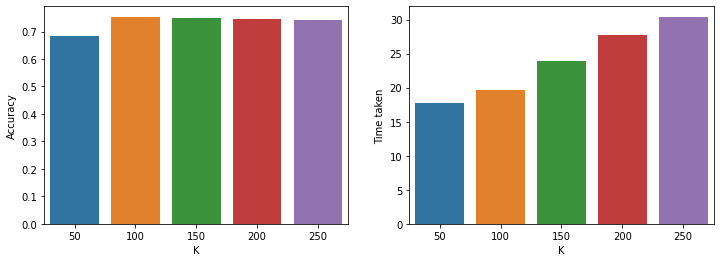

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=list(range(50, 251, 50)), y=ie_scores, ax=ax1)
ax1.set_xlabel("K")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=list(range(50, 251, 50)), y=ie_times, ax=ax2)
ax2.set_xlabel("K")
ax2.set_ylabel("Time taken")
plt.show()

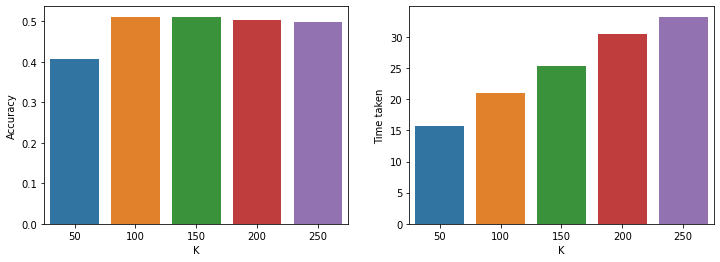

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=list(range(50, 251, 50)), y=domaux_scores, ax=ax1)
ax1.set_xlabel("K")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=list(range(50, 251, 50)), y=domaux_times, ax=ax2)
ax2.set_xlabel("K")
ax2.set_ylabel("Time taken")
plt.show()

100 parameters gives the best result for both.

In [ ]:
results[8][0] = ie_scores[1]
results[8][1] = domaux_scores[1]

In [ ]:
svd = TruncatedSVD(n_components=100)
x_t = svd.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

predicted_functions = []

for i in range(1,3):
  start_time = time.time()
  rf = RandomForestClassifier(class_weight='balanced')
  rf.fit(x_train, y_train.iloc[:,i].tolist())
  y_pred = rf.predict(x_test)
  print(axes[i-1])
  score = rf.score(x_test, y_test.iloc[:,i])
  predicted_functions.append(y_pred)

mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

score = accuracy_score(mbti_test, mbti_pred)
results[8][2] = score
print(score)
print(classification_report(mbti_test, mbti_pred))

I/E
dominant_auxiliary
0.41239545357066265
              precision    recall  f1-score   support

        ENFJ       0.31      0.16      0.22       311
        ENFP       0.51      0.42      0.46       403
        ENTJ       0.61      0.52      0.57       395
        ENTP       0.57      0.37      0.45       430
        ESFJ       0.00      0.00      0.00        42
        ESFP       0.00      0.00      0.00        71
        ESTJ       0.81      0.42      0.55       106
        ESTP       0.77      0.72      0.75       396
        INFJ       0.30      0.58      0.39       411
        INFP       0.28      0.48      0.36       378
        INTJ       0.28      0.51      0.36       367
        INTP       0.33      0.48      0.39       407
        ISFJ       0.30      0.03      0.05       120
        ISFP       0.61      0.17      0.26       167
        ISTJ       0.24      0.15      0.19       247
        ISTP       0.78      0.33      0.46       412

    accuracy                         

## Random Forest with TF-IDF + Resampling + Truncated SVD

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))
ie_scores = []
ie_times = []
domaux_scores = []
domaux_times = []

In [ ]:
def predict(k):
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  y_train = toFunction(pd.DataFrame({'type':y_train}))
  y_test = toFunction(pd.DataFrame({'type':y_test}))

  predicted_functions = []
  
  for i in range(1,3):
    start_time = time.time()
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(x_train, y_train.iloc[:,i].tolist())
    y_pred = rf.predict(x_test)
    print(axes[i-1])
    score = rf.score(x_test, y_test.iloc[:,i])
    [ie_scores, domaux_scores][i-1].append(score)
    [ie_times, domaux_times][i-1].append(time.time() - start_time)
    print(score)
    print(classification_report(y_test.iloc[:,i], y_pred))
    predicted_functions.append(y_pred)

  mbti_pred = toMbti(predicted_functions)
  mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

  print(accuracy_score(mbti_test, mbti_pred))
  print(classification_report(mbti_test, mbti_pred))


In [ ]:
for k in range(50, 251, 50):
  print(f'k: {k}')
  predict(k)

k: 50
I/E
0.8451640574737294
              precision    recall  f1-score   support

           E       0.88      0.77      0.82      2154
           I       0.82      0.91      0.86      2509

    accuracy                           0.85      4663
   macro avg       0.85      0.84      0.84      4663
weighted avg       0.85      0.85      0.84      4663

dominant_auxiliary
0.7250696976195582
              precision    recall  f1-score   support

          FN       0.67      0.76      0.71       689
          FS       0.76      0.56      0.65       209
          NF       0.70      0.77      0.73       814
          NT       0.62      0.69      0.65       797
          SF       0.76      0.54      0.63       191
          ST       0.89      0.80      0.84       643
          TN       0.70      0.69      0.70       802
          TS       0.89      0.75      0.82       518

    accuracy                           0.73      4663
   macro avg       0.75      0.70      0.72      4663
weighted a

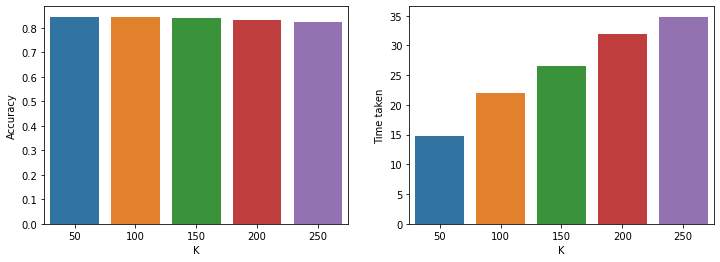

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=list(range(50, 251, 50)), y=ie_scores, ax=ax1)
ax1.set_xlabel("K")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=list(range(50, 251, 50)), y=ie_times, ax=ax2)
ax2.set_xlabel("K")
ax2.set_ylabel("Time taken")
plt.show()

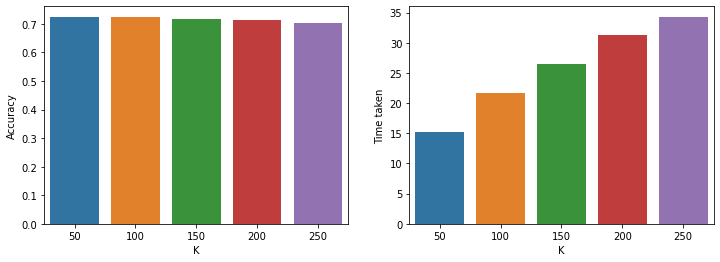

In [ ]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(x=list(range(50, 251, 50)), y=domaux_scores, ax=ax1)
ax1.set_xlabel("K")
ax1.set_ylabel("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(x=list(range(50, 251, 50)), y=domaux_times, ax=ax2)
ax2.set_xlabel("K")
ax2.set_ylabel("Time taken")
plt.show()

50 parameters seems to be the best, although since they all have similar accuracies, we take K = 50 majorly for the shorter run times.

In [ ]:
results[9][0] = ie_scores[0]
results[9][1] = domaux_scores[0]

In [ ]:
svd = TruncatedSVD(n_components=50)
x_t = svd.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

predicted_functions = []

for i in range(1,3):
  start_time = time.time()
  rf = RandomForestClassifier(class_weight='balanced')
  rf.fit(x_train, y_train.iloc[:,i].tolist())
  y_pred = rf.predict(x_test)
  print(axes[i-1])
  score = rf.score(x_test, y_test.iloc[:,i])
  predicted_functions.append(y_pred)

mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

score = accuracy_score(mbti_test, mbti_pred)
results[9][2] = score
print(score)
print(classification_report(mbti_test, mbti_pred))

I/E
dominant_auxiliary
0.6416470083637144
              precision    recall  f1-score   support

        ENFJ       0.73      0.61      0.67       311
        ENFP       0.69      0.71      0.70       403
        ENTJ       0.86      0.76      0.81       395
        ENTP       0.67      0.49      0.57       430
        ESFJ       0.51      0.43      0.47        42
        ESFP       0.78      0.44      0.56        71
        ESTJ       0.78      0.69      0.73       106
        ESTP       0.95      0.87      0.91       396
        INFJ       0.53      0.63      0.58       411
        INFP       0.48      0.67      0.56       378
        INTJ       0.34      0.56      0.43       367
        INTP       0.51      0.49      0.50       407
        ISFJ       0.62      0.53      0.57       120
        ISFP       0.75      0.56      0.64       167
        ISTJ       0.75      0.65      0.70       247
        ISTP       0.89      0.72      0.80       412

    accuracy                          

## KNN with Bag of Words + Resampling + Truncated SVD

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_bag, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

ie_scores = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ie_times = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
domaux_scores = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
domaux_times = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
def predict(k):
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  y_train = toFunction(pd.DataFrame({'type':y_train}))
  y_test = toFunction(pd.DataFrame({'type':y_test}))

  predicted_functions = []
  
  for i in range(1,3):
    best_score = 0
    best_pred = []
    smote = SMOTE()
    x_r, y_r = smote.fit_resample(x_train, y_train.iloc[:,i].tolist())
    for nn in range(20,201,20):
      print(f'Neighbors: {nn}')
      start_time = time.time()
      knn = KNeighborsClassifier(n_neighbors = nn)
      knn.fit(x_r, y_r)
      y_pred = knn.predict(x_test)
      print(axes[i-1])
      score = knn.score(x_test, y_test.iloc[:,i])
      if score > best_score:
        best_score = score
        best_pred = y_pred
      [ie_scores, domaux_scores][i-1][k // 50 - 1][nn // 20 - 1] = score
      [ie_times, domaux_times][i-1][k // 50 - 1][nn // 20 - 1] = time.time() - start_time
      print(score)
      print(classification_report(y_test.iloc[:,i], y_pred))
    predicted_functions.append(best_pred)

  mbti_pred = toMbti(predicted_functions)
  mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

  print(accuracy_score(mbti_test, mbti_pred))
  print(classification_report(mbti_test, mbti_pred))

In [ ]:
print('k: 50')
predict(50)

k: 50
Neighbors: 20
I/E
0.5931803559939953
              precision    recall  f1-score   support

           E       0.54      0.86      0.66      2154
           I       0.75      0.37      0.49      2509

    accuracy                           0.59      4663
   macro avg       0.64      0.61      0.58      4663
weighted avg       0.65      0.59      0.57      4663

Neighbors: 40
I/E
0.6066909714775895
              precision    recall  f1-score   support

           E       0.55      0.88      0.67      2154
           I       0.78      0.37      0.51      2509

    accuracy                           0.61      4663
   macro avg       0.66      0.63      0.59      4663
weighted avg       0.67      0.61      0.58      4663

Neighbors: 60
I/E
0.611194509972121
              precision    recall  f1-score   support

           E       0.55      0.88      0.68      2154
           I       0.79      0.38      0.51      2509

    accuracy                           0.61      4663
   macro avg

In [ ]:
print('k: 100')
predict(100)

k: 100
Neighbors: 20
I/E
0.5378511687754665
              precision    recall  f1-score   support

           E       0.50      0.96      0.66      2154
           I       0.85      0.17      0.29      2509

    accuracy                           0.54      4663
   macro avg       0.67      0.57      0.47      4663
weighted avg       0.69      0.54      0.46      4663

Neighbors: 40
I/E
0.5327042676388591
              precision    recall  f1-score   support

           E       0.50      0.98      0.66      2154
           I       0.88      0.15      0.26      2509

    accuracy                           0.53      4663
   macro avg       0.69      0.56      0.46      4663
weighted avg       0.70      0.53      0.44      4663

Neighbors: 60
I/E
0.5301308170705554
              precision    recall  f1-score   support

           E       0.50      0.98      0.66      2154
           I       0.90      0.14      0.25      2509

    accuracy                           0.53      4663
   macro a

In [ ]:
print('k: 150')
predict(150)

k: 150
Neighbors: 20
I/E
0.4872399742654943
              precision    recall  f1-score   support

           E       0.47      0.99      0.64      2154
           I       0.88      0.05      0.10      2509

    accuracy                           0.49      4663
   macro avg       0.68      0.52      0.37      4663
weighted avg       0.69      0.49      0.35      4663

Neighbors: 40
I/E
0.48059189363070987
              precision    recall  f1-score   support

           E       0.47      0.99      0.64      2154
           I       0.88      0.04      0.08      2509

    accuracy                           0.48      4663
   macro avg       0.68      0.52      0.36      4663
weighted avg       0.69      0.48      0.34      4663

Neighbors: 60
I/E
0.4784473514904568
              precision    recall  f1-score   support

           E       0.47      1.00      0.64      2154
           I       0.91      0.03      0.07      2509

    accuracy                           0.48      4663
   macro 

In [ ]:
print('k: 200')
predict(200)

k: 200
Neighbors: 20
I/E
0.46879691185931804
              precision    recall  f1-score   support

           E       0.46      0.99      0.63      2154
           I       0.78      0.02      0.04      2509

    accuracy                           0.47      4663
   macro avg       0.62      0.51      0.33      4663
weighted avg       0.63      0.47      0.31      4663

Neighbors: 40
I/E
0.46922582028736864
              precision    recall  f1-score   support

           E       0.47      1.00      0.63      2154
           I       0.89      0.02      0.03      2509

    accuracy                           0.47      4663
   macro avg       0.68      0.51      0.33      4663
weighted avg       0.69      0.47      0.31      4663

Neighbors: 60
I/E
0.4677246407891915
              precision    recall  f1-score   support

           E       0.46      1.00      0.63      2154
           I       0.85      0.01      0.03      2509

    accuracy                           0.47      4663
   macro

In [ ]:
print('k: 250')
predict(250)

k: 250
Neighbors: 20
I/E
0.4677246407891915
              precision    recall  f1-score   support

           E       0.46      1.00      0.63      2154
           I       0.83      0.01      0.03      2509

    accuracy                           0.47      4663
   macro avg       0.65      0.51      0.33      4663
weighted avg       0.66      0.47      0.31      4663

Neighbors: 40
I/E
0.4670812781471156
              precision    recall  f1-score   support

           E       0.46      1.00      0.63      2154
           I       0.85      0.01      0.02      2509

    accuracy                           0.47      4663
   macro avg       0.66      0.50      0.33      4663
weighted avg       0.67      0.47      0.30      4663

Neighbors: 60
I/E
0.46558009864893846
              precision    recall  f1-score   support

           E       0.46      1.00      0.63      2154
           I       0.84      0.01      0.02      2509

    accuracy                           0.47      4663
   macro 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


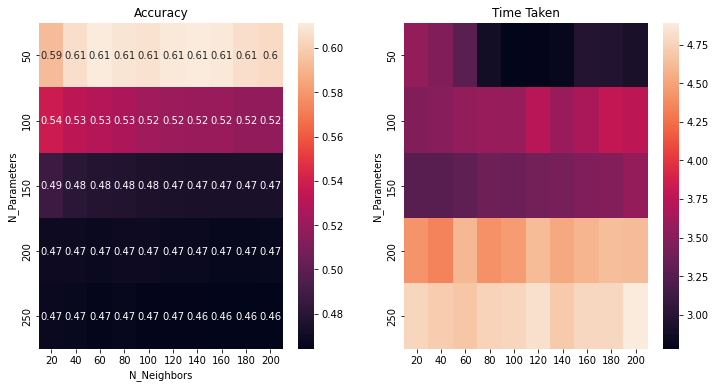

In [ ]:
ie_scores_df = pd.DataFrame(ie_scores, index=range(50, 251, 50), columns=range(20, 201, 20))
ie_times_df = pd.DataFrame(ie_times, index=range(50, 251, 50), columns=range(20, 201, 20))
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(ie_scores_df, annot=True, ax=ax1)
ax1.set_xlabel("N_Neighbors")
ax1.set_ylabel("N_Parameters")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(ie_times_df, ax=ax2)
ax1.set_xlabel("N_Neighbors")
ax2.set_ylabel("N_Parameters")
ax2.set_title("Time Taken")

plt.show()

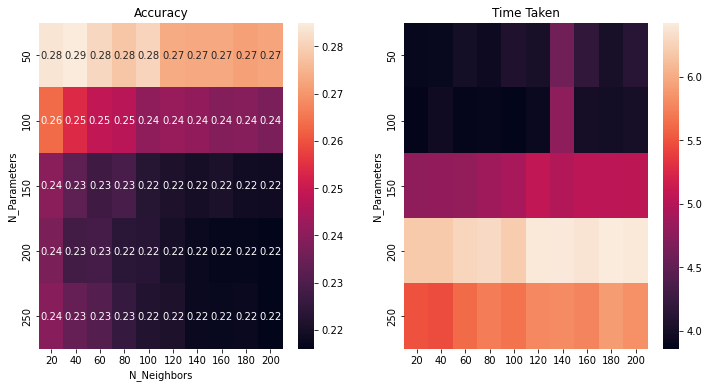

In [ ]:
domaux_scores_df = pd.DataFrame(domaux_scores, index=range(50, 251, 50), columns=range(20, 201, 20))
domaux_times_df = pd.DataFrame(domaux_times, index=range(50, 251, 50), columns=range(20, 201, 20))
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(domaux_scores_df, annot=True, ax=ax1)
ax1.set_xlabel("N_Neighbors")
ax1.set_ylabel("N_Parameters")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(domaux_times_df, ax=ax2)
ax1.set_xlabel("N_Neighbors")
ax2.set_ylabel("N_Parameters")
ax2.set_title("Time Taken")

plt.show()

In [ ]:
results[10][0] = ie_scores_df.loc[50, 140]
results[10][1] = domaux_scores_df.loc[50, 40]

svd = TruncatedSVD(n_components=50)
x_t = svd.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

predicted_functions = []

smote = SMOTE()
x_r, y_r = smote.fit_resample(x_train, y_train.iloc[:,1].tolist())
knn = KNeighborsClassifier(n_neighbors = 140)
knn.fit(x_r, y_r)
y_pred = knn.predict(x_test)
predicted_functions.append(y_pred)

smote = SMOTE()
x_r, y_r = smote.fit_resample(x_train, y_train.iloc[:,2].tolist())
knn = KNeighborsClassifier(n_neighbors = 40)
knn.fit(x_r, y_r)
y_pred = knn.predict(x_test)
predicted_functions.append(y_pred)

mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

score = accuracy_score(mbti_test, mbti_pred)
results[10][2] = score
print(score)
print(classification_report(mbti_test, mbti_pred))

0.19322324683680034
              precision    recall  f1-score   support

        ENFJ       0.17      0.14      0.15       311
        ENFP       0.48      0.15      0.22       403
        ENTJ       0.34      0.18      0.24       395
        ENTP       0.35      0.13      0.19       430
        ESFJ       0.01      0.17      0.02        42
        ESFP       0.03      0.39      0.06        71
        ESTJ       0.10      0.56      0.17       106
        ESTP       0.57      0.81      0.67       396
        INFJ       0.38      0.08      0.14       411
        INFP       0.27      0.13      0.18       378
        INTJ       0.38      0.05      0.08       367
        INTP       0.53      0.07      0.12       407
        ISFJ       0.05      0.13      0.07       120
        ISFP       0.12      0.17      0.14       167
        ISTJ       0.38      0.06      0.11       247
        ISTP       0.24      0.16      0.19       412

    accuracy                           0.19      4663
   mac

## KNN with TF-IDF + Resampling + TruncatedSVD

In [ ]:
axes = ['I/E', "dominant_auxiliary"]
under = RandomUnderSampler(sampling_strategy = dict(np.minimum(data['type'].value_counts(), 2000)))
x, y = under.fit_resample(x_tfidf, data['type'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

ie_scores = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
ie_times = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
domaux_scores = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
domaux_times = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
def predict(k):
  svd = TruncatedSVD(n_components=k)
  x_t = svd.fit_transform(x)

  x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
  y_train = toFunction(pd.DataFrame({'type':y_train}))
  y_test = toFunction(pd.DataFrame({'type':y_test}))

  predicted_functions = []
  
  for i in range(1,3):
    best_score = 0
    best_pred = []
    smote = SMOTE()
    x_r, y_r = smote.fit_resample(x_train, y_train.iloc[:,i].tolist())
    for nn in range(20,201,20):
      print(f'Neighbors: {nn}')
      start_time = time.time()
      knn = KNeighborsClassifier(n_neighbors = nn)
      knn.fit(x_r, y_r)
      y_pred = knn.predict(x_test)
      print(axes[i-1])
      score = knn.score(x_test, y_test.iloc[:,i])
      if score > best_score:
        best_score = score
        best_pred = y_pred
      [ie_scores, domaux_scores][i-1][k // 50 - 1][nn // 20 - 1] = score
      [ie_times, domaux_times][i-1][k // 50 - 1][nn // 20 - 1] = time.time() - start_time
      print(score)
      print(classification_report(y_test.iloc[:,i], y_pred))
    predicted_functions.append(best_pred)

  mbti_pred = toMbti(predicted_functions)
  mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

  print(accuracy_score(mbti_test, mbti_pred))
  print(classification_report(mbti_test, mbti_pred))

In [ ]:
print('k: 50')
predict(50)

k: 50
Neighbors: 20
I/E
0.8443062406176282
              precision    recall  f1-score   support

           E       0.81      0.86      0.84      2154
           I       0.88      0.83      0.85      2509

    accuracy                           0.84      4663
   macro avg       0.84      0.85      0.84      4663
weighted avg       0.85      0.84      0.84      4663

Neighbors: 40
I/E
0.8539566802487669
              precision    recall  f1-score   support

           E       0.83      0.86      0.84      2154
           I       0.88      0.85      0.86      2509

    accuracy                           0.85      4663
   macro avg       0.85      0.85      0.85      4663
weighted avg       0.85      0.85      0.85      4663

Neighbors: 60
I/E
0.8586746729573236
              precision    recall  f1-score   support

           E       0.84      0.85      0.85      2154
           I       0.87      0.86      0.87      2509

    accuracy                           0.86      4663
   macro av

In [ ]:
print('k: 100')
predict(100)

k: 100
Neighbors: 20
I/E
0.7574522839373794
              precision    recall  f1-score   support

           E       0.67      0.93      0.78      2154
           I       0.91      0.61      0.73      2509

    accuracy                           0.76      4663
   macro avg       0.79      0.77      0.75      4663
weighted avg       0.80      0.76      0.75      4663

Neighbors: 40
I/E
0.7701050825648724
              precision    recall  f1-score   support

           E       0.68      0.94      0.79      2154
           I       0.92      0.63      0.75      2509

    accuracy                           0.77      4663
   macro avg       0.80      0.78      0.77      4663
weighted avg       0.81      0.77      0.77      4663

Neighbors: 60
I/E
0.7743941668453785
              precision    recall  f1-score   support

           E       0.69      0.94      0.79      2154
           I       0.92      0.64      0.75      2509

    accuracy                           0.77      4663
   macro a

In [ ]:
print('k: 150')
predict(150)

k: 150
Neighbors: 20
I/E
0.6242762170276646
              precision    recall  f1-score   support

           E       0.55      0.97      0.70      2154
           I       0.93      0.33      0.48      2509

    accuracy                           0.62      4663
   macro avg       0.74      0.65      0.59      4663
weighted avg       0.76      0.62      0.59      4663

Neighbors: 40
I/E
0.623847308599614
              precision    recall  f1-score   support

           E       0.55      0.98      0.71      2154
           I       0.94      0.32      0.48      2509

    accuracy                           0.62      4663
   macro avg       0.75      0.65      0.59      4663
weighted avg       0.76      0.62      0.58      4663

Neighbors: 60
I/E
0.6176281363928802
              precision    recall  f1-score   support

           E       0.55      0.97      0.70      2154
           I       0.93      0.31      0.47      2509

    accuracy                           0.62      4663
   macro av

In [ ]:
print('k: 200')
predict(200)

k: 200
Neighbors: 20
I/E
0.5322753592108085
              precision    recall  f1-score   support

           E       0.50      0.99      0.66      2154
           I       0.92      0.14      0.25      2509

    accuracy                           0.53      4663
   macro avg       0.71      0.56      0.45      4663
weighted avg       0.73      0.53      0.44      4663

Neighbors: 40
I/E
0.527771820716277
              precision    recall  f1-score   support

           E       0.49      0.99      0.66      2154
           I       0.94      0.13      0.23      2509

    accuracy                           0.53      4663
   macro avg       0.72      0.56      0.44      4663
weighted avg       0.73      0.53      0.43      4663

Neighbors: 60
I/E
0.5219815569375938
              precision    recall  f1-score   support

           E       0.49      0.99      0.66      2154
           I       0.95      0.12      0.21      2509

    accuracy                           0.52      4663
   macro av

In [ ]:
print('k: 250')
predict(250)

k: 250
Neighbors: 20
I/E
0.5026806776753163
              precision    recall  f1-score   support

           E       0.48      0.99      0.65      2154
           I       0.92      0.08      0.15      2509

    accuracy                           0.50      4663
   macro avg       0.70      0.54      0.40      4663
weighted avg       0.72      0.50      0.38      4663

Neighbors: 40
I/E
0.4973193223246837
              precision    recall  f1-score   support

           E       0.48      1.00      0.65      2154
           I       0.95      0.07      0.13      2509

    accuracy                           0.50      4663
   macro avg       0.71      0.53      0.39      4663
weighted avg       0.73      0.50      0.37      4663

Neighbors: 60
I/E
0.49152905854600043
              precision    recall  f1-score   support

           E       0.48      1.00      0.64      2154
           I       0.94      0.06      0.11      2509

    accuracy                           0.49      4663
   macro 

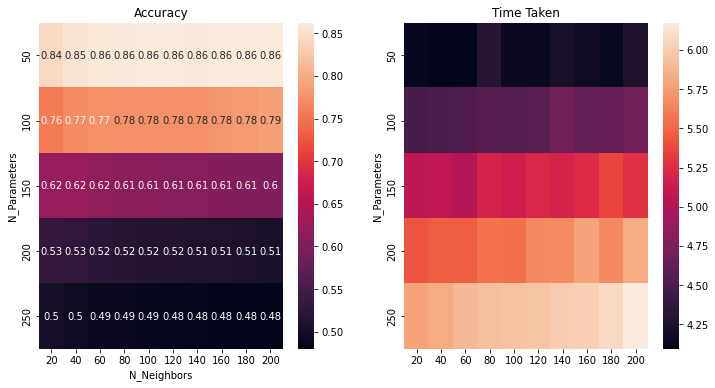

In [ ]:
ie_scores_df = pd.DataFrame(ie_scores, index=range(50, 251, 50), columns=range(20, 201, 20))
ie_times_df = pd.DataFrame(ie_times, index=range(50, 251, 50), columns=range(20, 201, 20))
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(ie_scores_df, annot=True, ax=ax1)
ax1.set_xlabel("N_Neighbors")
ax1.set_ylabel("N_Parameters")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(ie_times_df, ax=ax2)
ax1.set_xlabel("N_Neighbors")
ax2.set_ylabel("N_Parameters")
ax2.set_title("Time Taken")

plt.show()

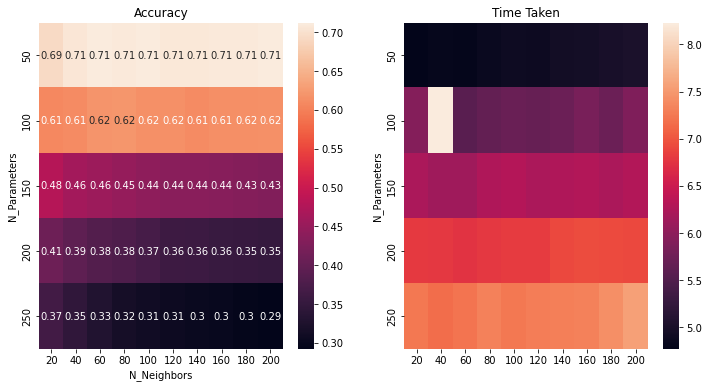

In [ ]:
domaux_scores_df = pd.DataFrame(domaux_scores, index=range(50, 251, 50), columns=range(20, 201, 20))
domaux_times_df = pd.DataFrame(domaux_times, index=range(50, 251, 50), columns=range(20, 201, 20))
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(domaux_scores_df, annot=True, ax=ax1)
ax1.set_xlabel("N_Neighbors")
ax1.set_ylabel("N_Parameters")
ax1.set_title("Accuracy")
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(domaux_times_df, ax=ax2)
ax1.set_xlabel("N_Neighbors")
ax2.set_ylabel("N_Parameters")
ax2.set_title("Time Taken")

plt.show()

In [ ]:
results[11][0] = ie_scores_df.loc[50, 140]
results[11][1] = domaux_scores_df.loc[50, 140]

svd = TruncatedSVD(n_components=50)
x_t = svd.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size=0.2, random_state=0)
y_train = toFunction(pd.DataFrame({'type':y_train}))
y_test = toFunction(pd.DataFrame({'type':y_test}))

predicted_functions = []

smote = SMOTE()
x_r, y_r = smote.fit_resample(x_train, y_train.iloc[:,1].tolist())
knn = KNeighborsClassifier(n_neighbors = 140)
knn.fit(x_r, y_r)
y_pred = knn.predict(x_test)
predicted_functions.append(y_pred)

smote = SMOTE()
x_r, y_r = smote.fit_resample(x_train, y_train.iloc[:,2].tolist())
knn = KNeighborsClassifier(n_neighbors = 140)
knn.fit(x_r, y_r)
y_pred = knn.predict(x_test)
predicted_functions.append(y_pred)

mbti_pred = toMbti(predicted_functions)
mbti_test = toMbti(y_test.iloc[:,1:5].T.values)

score = accuracy_score(mbti_test, mbti_pred)
results[11][2] = score
print(score)
print(classification_report(mbti_test, mbti_pred))

0.6626635213381943
              precision    recall  f1-score   support

        ENFJ       0.84      0.49      0.62       311
        ENFP       0.82      0.64      0.72       403
        ENTJ       0.85      0.78      0.82       395
        ENTP       0.75      0.60      0.66       430
        ESFJ       0.16      0.57      0.26        42
        ESFP       0.19      0.61      0.29        71
        ESTJ       0.49      0.71      0.58       106
        ESTP       0.85      0.93      0.88       396
        INFJ       0.68      0.51      0.58       411
        INFP       0.73      0.62      0.67       378
        INTJ       0.52      0.64      0.57       367
        INTP       0.68      0.62      0.65       407
        ISFJ       0.41      0.74      0.53       120
        ISFP       0.51      0.78      0.62       167
        ISTJ       0.79      0.57      0.66       247
        ISTP       0.78      0.77      0.78       412

    accuracy                           0.66      4663
   macr

## Conclusions

In [ ]:
results = pd.DataFrame(results, index=["naive_bayes", "naive_bayes", "svm", "svm", "linearsvc", "linearsvc", "logreg", "logreg", "random_forest", "random_forest", "knn", "knn"], columns=["i/e", "dominant_auxiliary", "overall"])
results["vectorization"] = ["bag_of_words", "tfidf"] * 6
results

,i/e,dominant_auxiliary,overall,vectorization
naive_bayes,0.859480,0.733855,0.642642,bag_of_words
naive_bayes,0.763270,0.337277,0.221929,tfidf
svm,0.860605,0.851169,0.678104,bag_of_words
svm,0.882694,0.810208,0.750590,tfidf
linearsvc,0.845807,0.746086,0.672957,bag_of_words
linearsvc,0.868540,0.797555,0.731074,tfidf
logreg,0.890120,0.811540,0.738239,bag_of_words
logreg,0.903790,0.830725,0.768690,tfidf
random_forest,0.754021,0.511259,0.412395,bag_of_words
random_forest,0.845164,0.725070,0.641647,tfidf


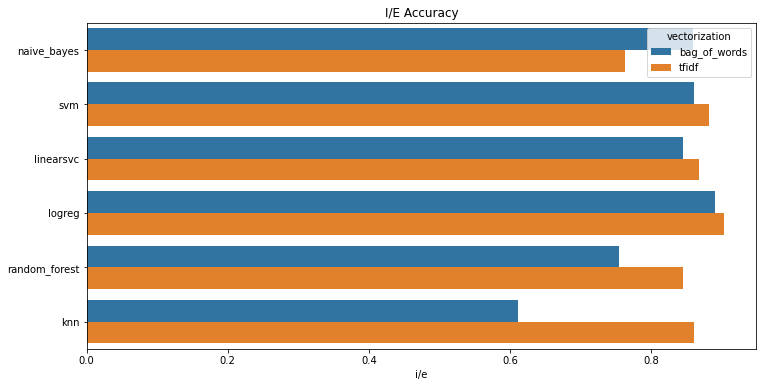

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=results["i/e"], y=results.index, hue=results.vectorization)
plt.title("I/E Accuracy")
plt.show()

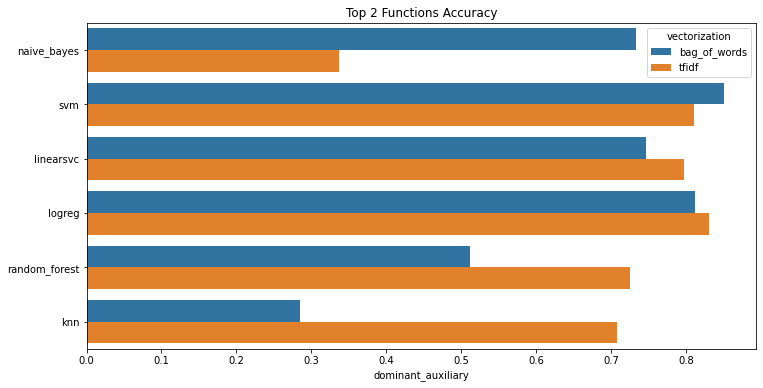

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=results["dominant_auxiliary"], y=results.index, hue=results.vectorization)
plt.title("Top 2 Functions Accuracy")
plt.show()

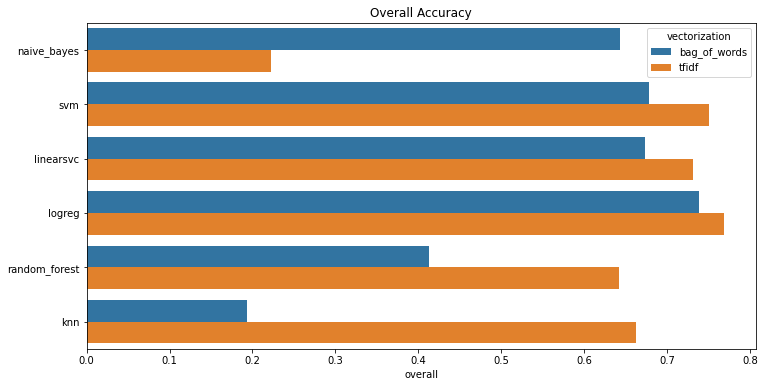

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=results["overall"], y=results.index, hue=results.vectorization)
plt.title("Overall Accuracy")
plt.show()

We observe similar trends to the direct predictions. tf-idf usually performs bag of words, with the strange exception of Naive Bayes, where the accuracy decreases dramatically. The dramatic differences for Random Forest and KNN are still present. Lastly, we see that the accuracies reached by this method are all lower than that of direct prediction, meaning that it is not a good method to use. 

In [ ]:
f = open("part_1_func.txt")
import json
results = json.loads(f.read())
results

[[0.859479588950693, 0.7338550014141605, 0.6426416517394173],
 [0.76326953898369, 0.3372772697275384, 0.2219289148675403],
 [0.8606047608835513, 0.8511687754664379, 0.6781042247480163],
 [0.8826935449281579, 0.8102080205876045, 0.7505897490885696],
 [0.8458074201158052, 0.7460862105940381, 0.6729573236114089],
 [0.8685395668024877, 0.7975552219601115, 0.7310744156122668],
 [0.8901197322522862, 0.8115395493542, 0.7382388988403884],
 [0.9037899500329971, 0.8307249929291977, 0.768690487413972],
 [0.7540210165129745, 0.5112588462363286, 0.41239545357066265],
 [0.8451640574737294, 0.7250696976195582, 0.6416470083637144],
 [0.6114089641861462, 0.2850096504396311, 0.19322324683680034],
 [0.8608192150975766, 0.7085567231396097, 0.6626635213381943]]

# Part 2 - Direct

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from IPython.display import clear_output
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#remove mbti-related text, so we dont classify a type based on how much some mbti string appears inside (not generalised)
#for loop creates all stuff like XXTJ etc, cause some posts contains thing like this

mbti_types = ['ISTJ', 'ISTP', 'ISFJ', 'ISFP', 'INTJ', 'INTP', 'INFJ', 'INFP', 'ESTJ', 'ESTP', 'ESFJ', 'ESFP', 'ENTJ', 'ENTP', 'ENFJ', 'ENFP']
mbti_stopwords = ['fe', 'fi', 'ne', 'ni', 'se', 'si', 'te', 'ti']
for i in mbti_types:
  for mask in range(17):
    tmp = list(i)
    for j in range(4):
      if pow(2, j) & mask != 0:
        tmp[j] = 'X'
    mbti_stopwords.append("".join(tmp))
    mbti_stopwords.append("".join(tmp) + "s")

In [ ]:
print(mbti_stopwords)

['fe', 'fi', 'ne', 'ni', 'se', 'si', 'te', 'ti', 'ISTJ', 'ISTJs', 'XSTJ', 'XSTJs', 'IXTJ', 'IXTJs', 'XXTJ', 'XXTJs', 'ISXJ', 'ISXJs', 'XSXJ', 'XSXJs', 'IXXJ', 'IXXJs', 'XXXJ', 'XXXJs', 'ISTX', 'ISTXs', 'XSTX', 'XSTXs', 'IXTX', 'IXTXs', 'XXTX', 'XXTXs', 'ISXX', 'ISXXs', 'XSXX', 'XSXXs', 'IXXX', 'IXXXs', 'XXXX', 'XXXXs', 'ISTJ', 'ISTJs', 'ISTP', 'ISTPs', 'XSTP', 'XSTPs', 'IXTP', 'IXTPs', 'XXTP', 'XXTPs', 'ISXP', 'ISXPs', 'XSXP', 'XSXPs', 'IXXP', 'IXXPs', 'XXXP', 'XXXPs', 'ISTX', 'ISTXs', 'XSTX', 'XSTXs', 'IXTX', 'IXTXs', 'XXTX', 'XXTXs', 'ISXX', 'ISXXs', 'XSXX', 'XSXXs', 'IXXX', 'IXXXs', 'XXXX', 'XXXXs', 'ISTP', 'ISTPs', 'ISFJ', 'ISFJs', 'XSFJ', 'XSFJs', 'IXFJ', 'IXFJs', 'XXFJ', 'XXFJs', 'ISXJ', 'ISXJs', 'XSXJ', 'XSXJs', 'IXXJ', 'IXXJs', 'XXXJ', 'XXXJs', 'ISFX', 'ISFXs', 'XSFX', 'XSFXs', 'IXFX', 'IXFXs', 'XXFX', 'XXFXs', 'ISXX', 'ISXXs', 'XSXX', 'XSXXs', 'IXXX', 'IXXXs', 'XXXX', 'XXXXs', 'ISFJ', 'ISFJs', 'ISFP', 'ISFPs', 'XSFP', 'XSFPs', 'IXFP', 'IXFPs', 'XXFP', 'XXFPs', 'ISXP', 'ISXPs',

In [ ]:
df = pd.read_csv('drive/MyDrive/CS5131_Project/mbti_full_pull.csv')
df

,author_flair_text,body,subreddit
0,INTJ,Knowing you're in INTJ is a tool for you to us...,intj
1,INTJ,You are truly an enlightened mastermind.,intj
2,"INFJ, 26F",You should :) it will help if you have a down ...,infj
3,INTP,I watch a bit of everything (including hentai)...,INTP
4,INTJ,I don't know if I would count this as a pet pe...,intj
...,...,...,...
1794011,INTP,Remind me! 40 hours,INTP
1794012,INTJ,We are seeing the start of a process that is g...,intj
1794013,INTJ,[NSFDL. I cry laughing at this every single ti...,intj
1794014,INFJ,Ravenclaw!,infj


In [ ]:
#data cleaning, drop the subreddit column
#types come from reddit users flair, which may not be just the mbti function
#so we extract the functions

df = df.drop(['subreddit'], axis = 1)
df.columns = ['type', 'text']
df['type'] = df['type'].str.upper()
for i in range(16):
  print(f"{mbti_types[i]} {i+1}/{16}") #debugging log
  df.loc[df['type'].str.contains(mbti_types[i]), 'type'] = mbti_types[i]
  clear_output(wait = True)
df = df[df['text'].str.len() >= 50]
df = df.reset_index(drop = True)
clear_output()
df

,type,text
0,INTJ,Knowing you're in INTJ is a tool for you to us...
1,INFJ,You should :) it will help if you have a down ...
2,INTP,I watch a bit of everything (including hentai)...
3,INTJ,I don't know if I would count this as a pet pe...
4,INTP,"Ah. \nNot sure how Se works for other types, b..."
...,...,...
1429109,INTJ,"Agree. Especially with the Beatles (""A Day in..."
1429110,INFJ,Yes!!! I experience extreme anxiety at the gym...
1429111,INTJ,We are seeing the start of a process that is g...
1429112,INTJ,[NSFDL. I cry laughing at this every single ti...


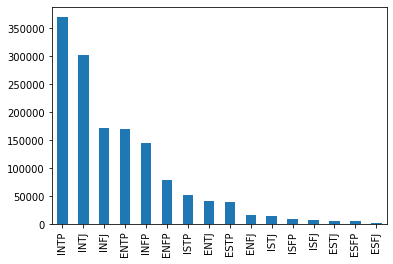

In [ ]:
df['type'].value_counts().plot(kind = 'bar')

In [ ]:
#Data is unbalanced, perform undersampling

under = RandomUnderSampler(sampling_strategy = dict(np.minimum(df['type'].value_counts(), 2000)))
df, df['type'] = under.fit_resample(df, df['type'])
df

,type,text
0,ENFJ,It is very difficult to understand. I have sto...
1,ENFJ,I have been documenting and reported once and ...
2,ENFJ,"Oh, I understand now, I apologise for that. It..."
3,ENFJ,Alright. So I'll try to ask about things he li...
4,ENFJ,"Oh, you mean romantically? It is very frustrat..."
...,...,...
31995,ISTP,"Didn't see this until today, got really upset,..."
31996,ISTP,I love star wars. It's very nostalgic for me. ...
31997,ISTP,Obvious insincerity repels people. Don't chang...
31998,ISTP,"I'll have to pick up some of his works then, b..."


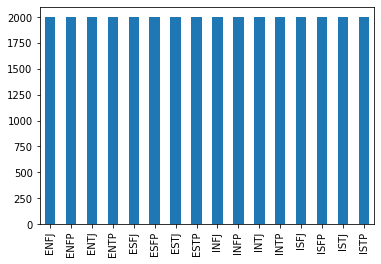

In [ ]:
df['type'].value_counts().plot(kind = 'bar')

In [ ]:
#clean data

count = 0 #to check progress

#get stopwords
stopwords = nltk.corpus.stopwords.words('english') + mbti_stopwords + [chr(i) for i in range(97, 123)]
stopwords = [i.lower() for i in stopwords]

def clean_text(row):
  #progress checking
  global count
  count += 1
  if count % 100 == 0:
    print(f"{count}/{df.shape[0]}")

  text = row['text']
  text = text.lower() #convert to lower case
  text = re.sub(r'http\S+', '', text) #remove links
  text = re.sub("\s+", " ", text) #remove multi spaces
  text = re.sub("\\n", "", text) #remove newlines
  text = re.sub("[^9A-Za-z ]", "" , text) #convert everything thats not a number, letter or space to empty char
  tokens = text.split(" ")
  tokens = [i for i in tokens if i not in stopwords] #remove stopwords
  text = ' '.join(tokens)
  text = re.sub("\s+", " ", text)
  row['text'] = text
  if count % 100 == 0:
    clear_output(wait = True)
  return row

df = df.apply(clean_text, axis = 1)
clear_output()

In [ ]:
df['text'].head(20)

0     difficult understand stopped trying rationaliz...
1                          documenting reported backed 
2     oh understand apologise makes sense theres not...
3     alright ill try ask things likes avoid putting...
4                oh mean romantically frustrating isnt 
5     definitely experience people go either way hyg...
6     mbti certification ago told good exercise know...
7     old would interested taking little test tell g...
8     well yes course thats said supposedly pointing...
9     likes much seem like think guys make distance ...
10     imagine even difference working together coul...
11      find smarter lot people hard ego dont know make
12    im glad hear accurate think definitely possibl...
13                 need affirmation people showing care
14    tell afraid looms back mind know everything kn...
15    dont think much colour preferences seem change...
16    oh gosh yes one years ago listened weeks weeks...
17    id tempted venture people might born certa

In [ ]:
vocab_size = 1000 # @param
embedding_dim =  64# @param
train_size = 0.8 # @param
max_length = 100 # @param
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
#if text is too long, truncate
df.loc[df['text'].str.len() >= max_length, 'text'] = df.loc[df['text'].str.len() >= max_length, 'text'].str[:max_length]

In [ ]:
text = list(df['text'])
types = df['type']

#60:30:10 train:val:test
x_train, x_val, y_train, y_val = train_test_split(text, types, test_size=0.4)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.25)

In [ ]:
#train tokenizer on training text

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'dont': 4,
 'get': 10,
 'im': 2,
 'know': 8,
 'like': 3,
 'one': 9,
 'people': 6,
 'really': 7,
 'think': 5}

In [ ]:
#tokenize text, pad with trailing 0s

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
#tokenize the labels to 1-16

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(mbti_types)

y_train_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
y_test_seq = np.array(label_tokenizer.texts_to_sequences(y_test))
y_val_seq = np.array(label_tokenizer.texts_to_sequences(y_val))

In [ ]:
#check that tokenisation works properly

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_article(x_train_pad[0]))
print('---')
print(x_train[0])

im even sure extroverted traits considering youve <OOV> <OOV> groups spend time small far <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
im even sure extroverted traits considering youve intentionally kept groups spend time small far mak


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim), #embedding layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout = 0.2, recurrent_dropout = 0.2)), #lstm layer
    tf.keras.layers.Dropout(rate=0.2), #dropout layer
    tf.keras.layers.Dense(embedding_dim, activation='relu'), #fully connected layer
    tf.keras.layers.Dense(17, activation='softmax') #dropout layer
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 17)                1105      
                                                                 
Total params: 139,409
Trainable params: 139,409
Non-trainable params: 0
________________________________________________

In [ ]:
#compile and train model, it performs very badly even when trying different architectures

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
early_stopping_monitor = EarlyStopping(patience=2)
history = model.fit(x_train_pad, y_train_seq, epochs=num_epochs, validation_data=(x_val_pad, y_val_seq), callbacks = [early_stopping_monitor])

Epoch 1/10
600/600 [==============================] - 170s 271ms/step - loss: 2.7665 - accuracy: 0.0765 - val_loss: 2.7265 - val_accuracy: 0.0991
Epoch 2/10
600/600 [==============================] - 168s 280ms/step - loss: 2.7029 - accuracy: 0.1108 - val_loss: 2.7097 - val_accuracy: 0.1072
Epoch 3/10
600/600 [==============================] - 131s 219ms/step - loss: 2.6559 - accuracy: 0.1304 - val_loss: 2.7026 - val_accuracy: 0.1085
Epoch 4/10
600/600 [==============================] - 140s 233ms/step - loss: 2.6162 - accuracy: 0.1496 - val_loss: 2.7100 - val_accuracy: 0.1111
Epoch 5/10
600/600 [==============================] - 139s 232ms/step - loss: 2.5818 - accuracy: 0.1654 - val_loss: 2.7204 - val_accuracy: 0.1141


In [ ]:
reverse_type_index = dict([(value, key) for (key, value) in label_tokenizer.word_index.items()])
reverse_type_index

{1: 'istj',
 2: 'istp',
 3: 'isfj',
 4: 'isfp',
 5: 'intj',
 6: 'intp',
 7: 'infj',
 8: 'infp',
 9: 'estj',
 10: 'estp',
 11: 'esfj',
 12: 'esfp',
 13: 'entj',
 14: 'entp',
 15: 'enfj',
 16: 'enfp'}

In [ ]:
#predict testing data
y_test_seq = model.predict(x_test_pad)
y_test_pred = []
for i in y_test_seq:
  y_test_pred.append(reverse_type_index[i.argmax()].upper())

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

        ENFJ       0.07      0.08      0.08       183
        ENFP       0.12      0.02      0.03       197
        ENTJ       0.11      0.06      0.08       201
        ENTP       0.07      0.10      0.08       191
        ESFJ       0.11      0.10      0.11       215
        ESFP       0.12      0.15      0.13       195
        ESTJ       0.16      0.20      0.18       201
        ESTP       0.22      0.36      0.27       213
        INFJ       0.07      0.08      0.08       201
        INFP       0.07      0.07      0.07       190
        INTJ       0.25      0.01      0.02       202
        INTP       0.09      0.09      0.09       196
        ISFJ       0.09      0.06      0.07       188
        ISFP       0.11      0.23      0.15       201
        ISTJ       0.12      0.19      0.15       192
        ISTP       0.06      0.01      0.02       234

    accuracy                           0.11      3200
   macro avg       0.11   

# Part 2 - Function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from IPython.display import clear_output
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#remove mbti-related text, so we dont classify a type based on how much some mbti string appears inside (not generalised)
#for loop creates all stuff like XXTJ etc, cause some posts contains thing like this

mbti_types = ['ISTJ', 'ISTP', 'ISFJ', 'ISFP', 'INTJ', 'INTP', 'INFJ', 'INFP', 'ESTJ', 'ESTP', 'ESFJ', 'ESFP', 'ENTJ', 'ENTP', 'ENFJ', 'ENFP']
mbti_stopwords = ['fe', 'fi', 'ne', 'ni', 'se', 'si', 'te', 'ti']
for i in mbti_types:
  for mask in range(17):
    tmp = list(i)
    for j in range(4):
      if pow(2, j) & mask != 0:
        tmp[j] = 'X'
    mbti_stopwords.append("".join(tmp))
    mbti_stopwords.append("".join(tmp) + "s")

In [ ]:
print(mbti_stopwords)

['fe', 'fi', 'ne', 'ni', 'se', 'si', 'te', 'ti', 'ISTJ', 'ISTJs', 'XSTJ', 'XSTJs', 'IXTJ', 'IXTJs', 'XXTJ', 'XXTJs', 'ISXJ', 'ISXJs', 'XSXJ', 'XSXJs', 'IXXJ', 'IXXJs', 'XXXJ', 'XXXJs', 'ISTX', 'ISTXs', 'XSTX', 'XSTXs', 'IXTX', 'IXTXs', 'XXTX', 'XXTXs', 'ISXX', 'ISXXs', 'XSXX', 'XSXXs', 'IXXX', 'IXXXs', 'XXXX', 'XXXXs', 'ISTJ', 'ISTJs', 'ISTP', 'ISTPs', 'XSTP', 'XSTPs', 'IXTP', 'IXTPs', 'XXTP', 'XXTPs', 'ISXP', 'ISXPs', 'XSXP', 'XSXPs', 'IXXP', 'IXXPs', 'XXXP', 'XXXPs', 'ISTX', 'ISTXs', 'XSTX', 'XSTXs', 'IXTX', 'IXTXs', 'XXTX', 'XXTXs', 'ISXX', 'ISXXs', 'XSXX', 'XSXXs', 'IXXX', 'IXXXs', 'XXXX', 'XXXXs', 'ISTP', 'ISTPs', 'ISFJ', 'ISFJs', 'XSFJ', 'XSFJs', 'IXFJ', 'IXFJs', 'XXFJ', 'XXFJs', 'ISXJ', 'ISXJs', 'XSXJ', 'XSXJs', 'IXXJ', 'IXXJs', 'XXXJ', 'XXXJs', 'ISFX', 'ISFXs', 'XSFX', 'XSFXs', 'IXFX', 'IXFXs', 'XXFX', 'XXFXs', 'ISXX', 'ISXXs', 'XSXX', 'XSXXs', 'IXXX', 'IXXXs', 'XXXX', 'XXXXs', 'ISFJ', 'ISFJs', 'ISFP', 'ISFPs', 'XSFP', 'XSFPs', 'IXFP', 'IXFPs', 'XXFP', 'XXFPs', 'ISXP', 'ISXPs',

In [ ]:
df = pd.read_csv('drive/MyDrive/CS5131_Project/mbti_full_pull.csv')
df

,author_flair_text,body,subreddit
0,INTJ,Knowing you're in INTJ is a tool for you to us...,intj
1,INTJ,You are truly an enlightened mastermind.,intj
2,"INFJ, 26F",You should :) it will help if you have a down ...,infj
3,INTP,I watch a bit of everything (including hentai)...,INTP
4,INTJ,I don't know if I would count this as a pet pe...,intj
...,...,...,...
1794011,INTP,Remind me! 40 hours,INTP
1794012,INTJ,We are seeing the start of a process that is g...,intj
1794013,INTJ,[NSFDL. I cry laughing at this every single ti...,intj
1794014,INFJ,Ravenclaw!,infj


In [ ]:
#data cleaning, drop the subreddit column
#types come from reddit users flair, which may not be just the mbti function
#so we extract the functions from the text

df = df.drop(['subreddit'], axis = 1)
df.columns = ['type', 'text']
df['type'] = df['type'].str.upper()
for i in range(16):
  print(f"{mbti_types[i]} {i+1}/{16}") #debugging log
  df.loc[df['type'].str.contains(mbti_types[i]), 'type'] = mbti_types[i]
  clear_output(wait = True)
df = df[df['text'].str.len() >= 50]
df = df.reset_index(drop = True)
clear_output()
df

,type,text
0,INTJ,Knowing you're in INTJ is a tool for you to us...
1,INFJ,You should :) it will help if you have a down ...
2,INTP,I watch a bit of everything (including hentai)...
3,INTJ,I don't know if I would count this as a pet pe...
4,INTP,"Ah. \nNot sure how Se works for other types, b..."
...,...,...
1429109,INTJ,"Agree. Especially with the Beatles (""A Day in..."
1429110,INFJ,Yes!!! I experience extreme anxiety at the gym...
1429111,INTJ,We are seeing the start of a process that is g...
1429112,INTJ,[NSFDL. I cry laughing at this every single ti...


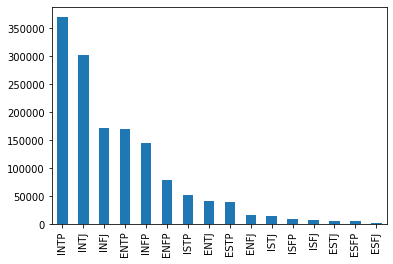

In [ ]:
df['type'].value_counts().plot(kind = 'bar')

In [ ]:
#Data is unbalanced, perform undersampling

under = RandomUnderSampler(sampling_strategy = dict(np.minimum(df['type'].value_counts(), 2000)))
df, df['type'] = under.fit_resample(df, df['type'])
df

,type,text
0,ENFJ,"&gt; When I'm in moments of anxiety/fear, I pr..."
1,ENFJ,To be honest I think jealousy is pretty unrela...
2,ENFJ,":D You're welcome, I just don't want you to be..."
3,ENFJ,Yea the level of anxiety that comes from worry...
4,ENFJ,"... Well, let's just say it's not for me #ENFJ..."
...,...,...
31995,ISTP,&gt;*Rant:* I just hate the word believe. It's...
31996,ISTP,Can't find credible reason to think he's Fi. B...
31997,ISTP,"What the fuck bro, I thought that was going to..."
31998,ISTP,Because you can't help but see the good in me ...


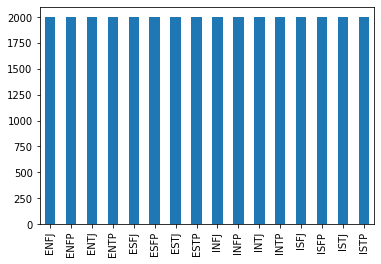

In [ ]:
df['type'].value_counts().plot(kind = 'bar')

In [ ]:
#clean data

count = 0 #to check progress

#get stopwords
stopwords = nltk.corpus.stopwords.words('english') + mbti_stopwords + [chr(i) for i in range(97, 123)]
stopwords = [i.lower() for i in stopwords]

def clean_text(row):
  #progress checking
  global count
  count += 1
  if count % 100 == 0:
    print(f"{count}/{df.shape[0]}")

  text = row['text']
  text = text.lower() #convert to lower case
  text = re.sub(r'http\S+', '', text) #remove links
  text = re.sub("\s+", " ", text) #remove multi spaces
  text = re.sub("\\n", "", text) #remove newlines
  text = re.sub("[^9A-Za-z ]", "" , text) #convert everything thats not a number, letter or space to empty char
  tokens = text.split(" ")
  tokens = [i for i in tokens if i not in stopwords] #remove stopwords
  text = ' '.join(tokens)
  text = re.sub("\s+", " ", text)
  row['text'] = text
  if count % 100 == 0:
    clear_output(wait = True)
  return row

df = df.apply(clean_text, axis = 1)
clear_output()

In [ ]:
df['text'].head(20)

0     gt im moments anxietyfear practice meditative ...
1     honest think jealousy pretty unrelated type lo...
2     youre welcome dont want unbalanced though alre...
3     yea level anxiety comes worrying knowing cant ...
4                              well lets say enfjthings
5             wait extraverted extroverted diff teh two
6     ooh bit late party heres take feel like tenden...
7     kind cat would build cat room would ever let c...
8     people need things cope yes agree coping mecha...
9                    im think come sanguinemelancholic 
10    haha thanks honestly expand actually bonded pa...
11    lol damn infjscaryblack hole sounds right want...
12    awareness contextual factors affect real relat...
13                  im fellow nfj definitely recognise 
14    well guess wish knew humans behind user names ...
15    gtim looking girl tapping pen like im seeing f...
16    well dont know know might good things things i...
17    point stereotypes useful someone whos atte

In [ ]:
axes = ['I/E', 'S/N', 'T/F', 'J/P']
for i in range(4):
  df[axes[i]] = df['type'].str[i]
df

,type,text,I/E,S/N,T/F,J/P
0,ENFJ,gt im moments anxietyfear practice meditative ...,E,N,F,J
1,ENFJ,honest think jealousy pretty unrelated type lo...,E,N,F,J
2,ENFJ,youre welcome dont want unbalanced though alre...,E,N,F,J
3,ENFJ,yea level anxiety comes worrying knowing cant ...,E,N,F,J
4,ENFJ,well lets say enfjthings,E,N,F,J
...,...,...,...,...,...,...
31995,ISTP,gtrant hate word believe abused religion lost ...,I,S,T,P
31996,ISTP,cant find credible reason think hes guess migh...,I,S,T,P
31997,ISTP,fuck bro thought going cool place mod posted b...,I,S,T,P
31998,ISTP,cant help see good right would never get along...,I,S,T,P


In [ ]:
vocab_size = 2000 # @param
embedding_dim =  64# @param
train_size = 0.8 # @param
max_length = 100 # @param
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
#if text is too long, truncate
df.loc[df['text'].str.len() >= max_length, 'text'] = df.loc[df['text'].str.len() >= max_length, 'text'].str[:max_length]

## I/E axis

In [ ]:
text = list(df['text'])
types = df['I/E']

#60:30:10 train:val:test
x_train, x_val, y_train, y_val = train_test_split(text, types, test_size=0.4)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.25)

In [ ]:
#train tokenizer on training text

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'dont': 4,
 'im': 2,
 'know': 9,
 'like': 3,
 'one': 7,
 'people': 5,
 'really': 8,
 'think': 6,
 'would': 10}

In [ ]:
#tokenize text, pad with trailing 0s

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
#tokenize the labels to 1-2

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(['I','E'])

y_train_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
y_test_seq = np.array(label_tokenizer.texts_to_sequences(y_test))
y_val_seq = np.array(label_tokenizer.texts_to_sequences(y_val))

In [ ]:
#convert to 0-1 instead of 1-2

y_train_seq = []
y_test_seq = []
y_val_seq = []
labels = ['I', 'E']

for i in y_train:
  y_train_seq.append([0] if i == labels[0] else [1])
for i in y_test:
  y_test_seq.append([0] if i == labels[0] else [1])
for i in y_val:
  y_val_seq.append([0] if i == labels[0] else [1])

y_train_seq = np.array(y_train_seq)
y_test_seq = np.array(y_test_seq)
y_val_seq = np.array(y_val_seq)

In [ ]:
#check that tokenisation works properly

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_article(x_train_pad[0]))
print('---')
print(x_train[0])

lol wonder high self <OOV> get used feeling like shit time thus feel like less shit higher <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
lol wonder high self esteem get used feeling like shit time thus feel like less shit higher baseline


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim), #embedding layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout = 0.2, recurrent_dropout = 0.2)), #lstm layer
    tf.keras.layers.Dropout(rate=0.2), #dropout layer
    tf.keras.layers.Dense(embedding_dim, activation='relu'), #fully connected layer
    tf.keras.layers.Dense(1, activation='sigmoid') #dropout layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 202,369
Trainable params: 202,369
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
num_epochs = 10
early_stopping_monitor = EarlyStopping(patience=2)
history = model.fit(x_train_pad, y_train_seq, epochs=num_epochs, validation_data=(x_val_pad, y_val_seq), callbacks = [early_stopping_monitor])

Epoch 1/10
600/600 [==============================] - 210s 343ms/step - loss: 0.6883 - accuracy: 0.5226 - auc: 0.5381 - val_loss: 0.6822 - val_accuracy: 0.5358 - val_auc: 0.5682
Epoch 2/10
600/600 [==============================] - 147s 246ms/step - loss: 0.6630 - accuracy: 0.5944 - auc: 0.6311 - val_loss: 0.6846 - val_accuracy: 0.5420 - val_auc: 0.5690
Epoch 3/10
600/600 [==============================] - 148s 246ms/step - loss: 0.6311 - accuracy: 0.6301 - auc: 0.6853 - val_loss: 0.7084 - val_accuracy: 0.5440 - val_auc: 0.5644


In [ ]:
#predict testing data, and convert to I/E
y_test_seq = model.predict(x_test_pad)
y_test_pred = []
for i in y_test_seq:
  if i[0] > 0.5:
    y_test_pred.append('I')
  else:
    y_test_pred.append('E')

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           E       0.44      0.48      0.46      1542
           I       0.48      0.44      0.46      1658

    accuracy                           0.46      3200
   macro avg       0.46      0.46      0.46      3200
weighted avg       0.46      0.46      0.46      3200



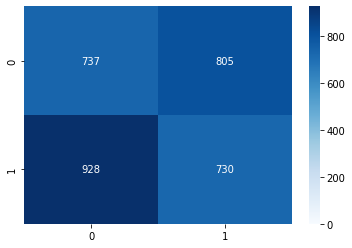

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", vmin=0)

# Part 2 - Clown?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from IPython.display import clear_output
from imblearn.under_sampling import RandomUnderSampler
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
mbti_types = ['ISTJ', 'ISTP', 'ISFJ', 'ISFP', 'INTJ', 'INTP', 'INFJ', 'INFP', 'ESTJ', 'ESTP', 'ESFJ', 'ESFP', 'ENTJ', 'ENTP', 'ENFJ', 'ENFP']

In [ ]:
max_length = 500 # @param
num_samples =  10000 # @param

In [ ]:
df = pd.read_csv('drive/MyDrive/CS5131_Project/mbti_full_pull.csv')

In [ ]:
df = df.drop(['subreddit'], axis = 1)
df.columns = ['type', 'text']
df['type'] = df['type'].str.upper()
for i in range(16):
  print(f"{mbti_types[i]} {i+1}/{16}")
  df.loc[df['type'].str.contains(mbti_types[i]), 'type'] = mbti_types[i]
  clear_output(wait = True)
df = df[df['text'].str.len() >= 50]
df = df.reset_index(drop = True)
clear_output()
df

,type,text
0,INTJ,Knowing you're in INTJ is a tool for you to us...
1,INFJ,You should :) it will help if you have a down ...
2,INTP,I watch a bit of everything (including hentai)...
3,INTJ,I don't know if I would count this as a pet pe...
4,INTP,"Ah. \nNot sure how Se works for other types, b..."
...,...,...
1429109,INTJ,"Agree. Especially with the Beatles (""A Day in..."
1429110,INFJ,Yes!!! I experience extreme anxiety at the gym...
1429111,INTJ,We are seeing the start of a process that is g...
1429112,INTJ,[NSFDL. I cry laughing at this every single ti...


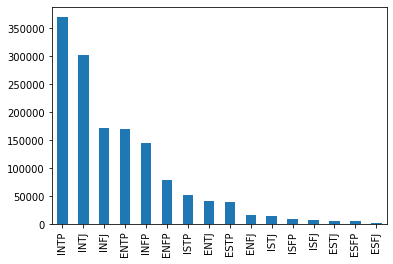

In [ ]:
df['type'].value_counts().plot(kind = 'bar')

In [ ]:
if num_samples != -1:
  under = RandomUnderSampler(sampling_strategy = dict(np.minimum(df['type'].value_counts(), num_samples)))
  df, df['type'] = under.fit_resample(df, df['type'])
  df

In [ ]:
df = df[df['text'].str.len()>=10]
df = df.reset_index(drop = True)
df

,type,text
0,ENFJ,and I envy P. It sucks being so bad at adaptin...
1,ENFJ,"Sure, I'd be happy to! Did I miss your answer..."
2,ENFJ,I think she was infp now that you mention it. ...
3,ENFJ,I'm ENFJ and I entirely agree with what OC sai...
4,ENFJ,This article is the result of over a month of ...
...,...,...
139318,ISTP,Power bottoms should know their place. \rDon't...
139319,ISTP,Thank you for this. Now I finally understand w...
139320,ISTP,I do all of those mentioned things by myself a...
139321,ISTP,The Soviet Union doesn't mean Marxism-Leninism...


In [ ]:
axes = ['I/E', 'S/N', 'T/F', 'J/P']
for i in range(4):
  df[axes[i]] = df['type'].str[i]
df

,type,text,I/E,S/N,T/F,J/P
0,ENFJ,and I envy P. It sucks being so bad at adaptin...,E,N,F,J
1,ENFJ,"Sure, I'd be happy to! Did I miss your answer...",E,N,F,J
2,ENFJ,I think she was infp now that you mention it. ...,E,N,F,J
3,ENFJ,I'm ENFJ and I entirely agree with what OC sai...,E,N,F,J
4,ENFJ,This article is the result of over a month of ...,E,N,F,J
...,...,...,...,...,...,...
139318,ISTP,Power bottoms should know their place. \rDon't...,I,S,T,P
139319,ISTP,Thank you for this. Now I finally understand w...,I,S,T,P
139320,ISTP,I do all of those mentioned things by myself a...,I,S,T,P
139321,ISTP,The Soviet Union doesn't mean Marxism-Leninism...,I,S,T,P


In [ ]:
count = 0

def clean_text(row):
  global count
  count += 1
  if count % 100 == 0:
    print(f"{count}/{df.shape[0]}")
  text = row['text']
  text = text.lower()
  text = re.sub(r'http\S+', '', text)
  text = re.sub("\s+", " ", text)
  text = re.sub("\\n", "", text)
  text = re.sub("[^9A-Za-z' ]", " " , text)
  tokens = text.split(" ")
  tokens = int((len(tokens) + max_length - 1) / max_length) * tokens
  tokens = tokens[:max_length]
  text = ' '.join(tokens)
  text = re.sub("\s+", " ", text)
  row['text'] = text
  if count % 100 == 0:
    clear_output(wait = True)
  return row

df = df.apply(clean_text, axis = 1)
clear_output()

## TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
x_tfidf = vectorizer.fit_transform(df['text'])

x_train, x_test, y_train, y_test = train_test_split(x_tfidf, df['I/E'], test_size=0.2, random_state=0)
lr = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
lr.fit(x_train, y_train)
score = lr.score(x_test, y_test)
print(score)
y_pred = lr.predict(x_test) 
print(classification_report(y_test, y_pred))

0.6208864166517136
              precision    recall  f1-score   support

           E       0.58      0.59      0.59     12572
           I       0.66      0.64      0.65     15293

    accuracy                           0.62     27865
   macro avg       0.62      0.62      0.62     27865
weighted avg       0.62      0.62      0.62     27865



## Count Vectorizer

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(df['text'])
pickle.dump(vectorizer, open('vectorizer.pickle', 'wb'))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_bag, df['I/E'], test_size=0.2, random_state=0)
nb = MultinomialNB(alpha = 1)
nb.fit(x_train, y_train)
score = nb.score(x_test, y_test)
print(score)
y_pred = nb.predict(x_test)
print(classification_report(y_test, y_pred))
pickle.dump(nb, open('IE_axis.pickle', 'wb'))

0.6285304144984748
              precision    recall  f1-score   support

           E       0.64      0.41      0.50     12572
           I       0.63      0.81      0.70     15293

    accuracy                           0.63     27865
   macro avg       0.63      0.61      0.60     27865
weighted avg       0.63      0.63      0.61     27865



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_bag, df['S/N'], test_size=0.2, random_state=0)
nb = MultinomialNB(alpha = 1)
nb.fit(x_train, y_train)
score = nb.score(x_test, y_test)
print(score)
y_pred = nb.predict(x_test)
print(classification_report(y_test, y_pred))
pickle.dump(nb, open('SN_axis.pickle', 'wb'))

0.6600035887313834
              precision    recall  f1-score   support

           N       0.67      0.81      0.73     16094
           S       0.64      0.46      0.53     11771

    accuracy                           0.66     27865
   macro avg       0.65      0.63      0.63     27865
weighted avg       0.66      0.66      0.65     27865



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_bag, df['T/F'], test_size=0.2, random_state=0)
nb = MultinomialNB(alpha = 1)
nb.fit(x_train, y_train)
score = nb.score(x_test, y_test)
print(score)
y_pred = nb.predict(x_test)
print(classification_report(y_test, y_pred))
pickle.dump(nb, open('TF_axis.pickle', 'wb'))

0.6381482146061367
              precision    recall  f1-score   support

           F       0.58      0.74      0.65     12763
           T       0.72      0.55      0.62     15102

    accuracy                           0.64     27865
   macro avg       0.65      0.65      0.64     27865
weighted avg       0.66      0.64      0.64     27865



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_bag, df['J/P'], test_size=0.2, random_state=0)
nb = MultinomialNB(alpha = 1)
nb.fit(x_train, y_train)
score = nb.score(x_test, y_test)
print(score)
y_pred = nb.predict(x_test)
print(classification_report(y_test, y_pred))
pickle.dump(nb, open('JP_axis.pickle', 'wb'))

0.615969854656379
              precision    recall  f1-score   support

           J       0.59      0.53      0.56     12791
           P       0.63      0.69      0.66     15074

    accuracy                           0.62     27865
   macro avg       0.61      0.61      0.61     27865
weighted avg       0.61      0.62      0.61     27865



# Helper

In [ ]:
f = open("part_1_func.txt", "w")
results

[[0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0]]

In [ ]:
# file read
import json
f = open("part_1_direct.txt")
results = json.loads(f.read())
results

[[0.677807108513246, 0.703125],
 [0.7615725464316018, 0.5418591496181767],
 [0.7981985846021874, 0.8185717349345915],
 [0.7520909285867468, 0.8046322110229466],
 [0.7544499249410251, 0.8108513832296804],
 [0.7323611408964186, 0.8027021230967188],
 [0.5065408535277718, 0.7259275144756594],
 [0.2451211666309243, 0.701050825648724],
 [0.7990428664921466, 0.8292658730158731]]